In [30]:
import sys
import itertools
import pandas as pd
import numpy as np
import pathlib

from tqdm.auto import tqdm

In [31]:
sys.path.append("../src")

from utils import number_split, create_mix

# Load Datasets

## Option 1: Load from preprocessed Toy dataset

In [3]:
df_imdb = pd.read_csv("../dataToy/horror_family.csv")

In [4]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

# Split original dataset into two
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_family = df_imdb.query("domain == 'Family'").reset_index(drop=True)


In [5]:
df_imdb.head()

id                                               text label  score  \
0  12390  Bizarre horror movie filled with famous faces ...   pos      8   
1  12385  Man, I really love the new DVD that Universal ...   pos      7   
2  12377  This happens to be one of my favorite horror f...   pos     10   
3  12365  I'm surprised that no one yet has mentioned th...   pos      7   
4  12370  Michael Winner is probably best known for his ...   pos      8   

                                                url     tconst   id_w_tag  \
0  http://www.imdb.com/title/tt0076683/usercomments  tt0076683  pos_12390   
1  http://www.imdb.com/title/tt0076683/usercomments  tt0076683  pos_12385   
2  http://www.imdb.com/title/tt0076683/usercomments  tt0076683  pos_12377   
3  http://www.imdb.com/title/tt0076683/usercomments  tt0076683  pos_12365   
4  http://www.imdb.com/title/tt0076683/usercomments  tt0076683  pos_12370   

     set titleType  primaryTitle originalTitle  isAdult  startYear endYear  \
0  train     movie  The Sentinel  The Sentinel        0       1977      \N   
1  train     movie  The Sentinel  The Sentinel        0       1977      \N   
2  train     movie  The Sentinel  The Sentinel        0       1977      \N   
3  train     movie  The Sentinel  The Sentinel        0       1977      \N   
4  train     movie  The Sentinel  The Sentinel        0       1977      \N   

  runtimeMinutes  genres  domain  label_binary  
0             92  Horror  Horror             1  
1             92  Horror  Horror             1  
2             92  Horror  Horror             1  
3             92  Horror  Horror             1  
4             92  Horror  Horror             1

In [6]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_family.groupby("label").size())

label
neg    3031
pos    1161
dtype: int64
label
neg    611
pos    769
dtype: int64


In [7]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_family.groupby("label_binary").size())

label_binary
0    3031
1    1161
dtype: int64
label_binary
0    611
1    769
dtype: int64


## Option 2: Download IMDB Dataset

The link to the original dataset used in this notebook: https://ai.stanford.edu/~amaas/data/sentiment/


For this demo, only data in `train` are used.


- Two provenances: genre-Horror, genre-Family
- Outcome: Positive, Negative

In [8]:
%%bash
cd ../dataToy

wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz >/dev/null 2>&1

tar -xf aclImdb_v1.tar.gz 

Process is interrupted.


In [ ]:
%%bash
cd ../dataToy

wget https://datasets.imdbws.com/title.basics.tsv.gz >/dev/null 2>&1

gzip -d title.basics.tsv.gz

In [ ]:
df_ls = []



basepath="../dataToy/aclImdb/"
set_name = "train"

tags = ["pos","neg"]


for tag in tags:
    id_ls = []
    score_ls = []
    text_ls = []
    label_ls = []

    url_ls = []
    tconst_ls = []
    
    path = pathlib.Path(basepath, set_name, tag)
    url_file = pathlib.Path(basepath, set_name, f"urls_{tag}.txt")
    
    with open(url_file, "r") as f:
        _allurls = f.readlines()
        url_ls.append([x.rstrip() for x in _allurls])
        tconst_ls.append([x.rstrip().split("/")[-2] for x in _allurls])
    
    for ifile in path.glob("*"):
        with open(ifile, "r") as f:
            txt = f.readlines()

            text_ls.append(" ".join(txt))





        _id, _score = ifile.with_suffix('').name.split("_")

        id_ls.append(int(_id))
        score_ls.append(_score)
        label_ls.append(tag)

    df_tmp = pd.DataFrame({"id":id_ls,
                         "text":text_ls,
                         "label":label_ls,
                         "score":score_ls,
                        })
    
    df_tmp = df_tmp.set_index('id')

    df_url = pd.DataFrame({"url":url_ls[0], "tconst":tconst_ls[0]})

    df_url.index.name = 'id'

    df_tmp = df_tmp.merge(df_url, on='id')



    assert df_tmp.index.nunique() == len(df_tmp)

    df_tmp['id_w_tag'] = df_tmp.index

    df_tmp['id_w_tag'] = df_tmp['id_w_tag'].apply(lambda x: tag + "_" + str(x))
    df_tmp = df_tmp.reset_index()
    
    df_tmp['set'] = set_name
    
    
    df_ls.append(df_tmp)
    
df = pd.concat(df_ls, ignore_index=True)

# get Genre
df_title_basics = pd.read_csv("../dataToy/title.basics.tsv", sep="\t")
df = df.merge(df_title_basics, on="tconst", how='inner')


# select Horror and Family
df_horror = df[df['genres'].str.contains("Horror")].reset_index(drop=True)
df_horror['domain'] = 'Horror'

df_family = df[df['genres'].str.contains("Family")].reset_index(drop=True)
df_family['domain'] = 'Family'


# Merge and Save
df_mix = pd.concat([df_horror, df_family]).reset_index(drop=True)

df_mix.to_csv("../dataToy/horror_family.csv", index=False)

In [ ]:
df_mix.head()

## Load AD datasets

In [11]:
!ls ../data

WLS-labels.csv              processed_pitt_dementia.tsv
processedWLS.tsv            wls_id_map_with_TICS.csv
processed_pitt_control.tsv


In [12]:
wls_labs = pd.read_csv('../data/wls_id_map_with_TICS.csv').dropna()

In [13]:
wls_labs.head()

Unnamed: 0    idtlkbnk  orig_id  z_q1i916re
0           0  2000000002  809455g        32.0
1           1  2000000007  824456s        37.0
2           2  2000000032  826601s        27.0
3           3  2000000047  810653g        33.0
7           7  2000000114  825454g        29.0

In [14]:
#Using TICS score threshold of less than or equal to 27 for dementia
wlabdict = dict(zip(wls_labs['idtlkbnk'],wls_labs['z_q1i916re'] <= 27))

In [15]:
import pandas as pd
wls_df = pd.read_csv('../data/processedWLS.tsv',sep="\t")

In [16]:
wls_df.head()

file                                               text
0  2000015784  Well i see a boy taking a cookie outof a cooki...
1  2000015088  The mother's doing dishes. She's naughty. She'...
2  2000015573  Okay. Somebody is into the cookie jar and he's...
3  2000015045  Okay. There's a young boy up on a chair that's...
4  2000015213  Kids are in the cookie jar. And the child is r...

In [17]:
wls_lab_df = wls_df[[x in wlabdict for x in wls_df['file']]]
wls_lab_df['dementia'] = [wlabdict[x] for x in wls_lab_df['file']] 

/var/folders/vv/_24hyv6s6ls80lmxgd5b5sr40000gn/T/ipykernel_66489/661003473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wls_lab_df['dementia'] = [wlabdict[x] for x in wls_lab_df['file']]


In [18]:
wls_lab_df.head()

file                                               text  dementia
0  2000015784  Well i see a boy taking a cookie outof a cooki...     False
1  2000015088  The mother's doing dishes. She's naughty. She'...     False
3  2000015045  Okay. There's a young boy up on a chair that's...     False
4  2000015213  Kids are in the cookie jar. And the child is r...      True
6  2000015187  Okay. Everything i see. I see a guy standing o...     False

In [19]:
import numpy as np
dem_df_dem = pd.read_csv("../data/processed_pitt_dementia.tsv", sep="\t")
dem_df_dem['dementia'] = np.ones(len(dem_df_dem))
dem_df_con = pd.read_csv("../data/processed_pitt_control.tsv", sep="\t")
dem_df_con['dementia'] = np.zeros(len(dem_df_con))
dem_lab_df = pd.concat([dem_df_dem,dem_df_con]).sample(frac=1).reset_index(drop=True)

In [20]:
#The two dataframes are now dem_lab_df (dementiabank) and wls_lab_df (wls)

In [21]:
dem_df_dem

file                                               text  dementia
0    172-1  Oh the water is running outof the sink. Mother...       1.0
1    154-1  this boy is getting cookies outof this jar. we...       1.0
2    039-0  Okay we see first of all the sink is overflowi...       1.0
3    120-1  okay. Okay. Okay. Well the boy is reaching for...       1.0
4    181-0  Well they x look like they're stealing cookies...       1.0
..     ...                                                ...       ...
300  014-2  Well this here is cookie jar. Looks like the t...       1.0
301  023-0  well i see the mother. What's she doing. Pouri...       1.0
302  526-1  There's a little boy or there's a little girl ...       1.0
303  010-2  What's happening there. Oh my. Poor kids. He's...       1.0
304  030-0  It's a picture of a kitchen. There's a child r...       1.0

[305 rows x 3 columns]

# Split

## Configs

In [22]:
s = []
s.append([[x, 1/x] for x in np.arange(1,10,0.1)])
s = np.array(s).flatten()
s = np.sort(s)

In [23]:
#configure the provenance-specific parameters for train/test splits
n_test = 500 #test set size
train_test_ratio = 4 #train/test ratio (4:1)

p_pos_train_z0_ls = [0.25,0.4,0.5,0.6,0.75] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.75,0.6,0.5,0.4,0.25] # probability of test set examples drawn from site/domain z1 being positive
# it would also be possible to expand p_pos_train parameters as a list to explore their influence

# fraction of both train/test data drawn from domain z1 irrespective of class label
# fraction drawn from z0 would be 1-p_mix_z1_ls
# this is a list of distributions, experiments will be conducted at each of these settings 
p_mix_z1_ls     = [0.5] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test is p(y=1|z=1) / p(y=1|z=0): the ratio between test set probabilities of the positive class by site/domain
#alpha_test_ls     = [0.125,0.25,0.5,1,2,4,8]

alpha_test_ls = np.arange(0,10,0.1)

#get a balanced range of alpha test
numvals = 103
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)
#could we reduce the base for more granularity

#alternative with narrower intervals
numvals = 1000
s = []
s.append([[x, 1/x] for x in np.arange(1,numvals//2,0.1)])
s = np.array(s).flatten()
#alpha_test_ls = np.sort(list(set(s)))

#check for balance 
print("balanced?",np.sum(alpha_test_ls > 1) - np.sum(alpha_test_ls < 1)==0)
#check for underflow/flow
print("underflow?",np.inf in alpha_test_ls)
#sns.distplot(np.log(alpha_test_ls) / np.log(base))
#print(alpha_test_ls)

balanced? True
underflow? False


/var/folders/vv/_24hyv6s6ls80lmxgd5b5sr40000gn/T/ipykernel_66489/1189599174.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(alpha_test_ls) / np.log(base))


<Axes: ylabel='Density'>

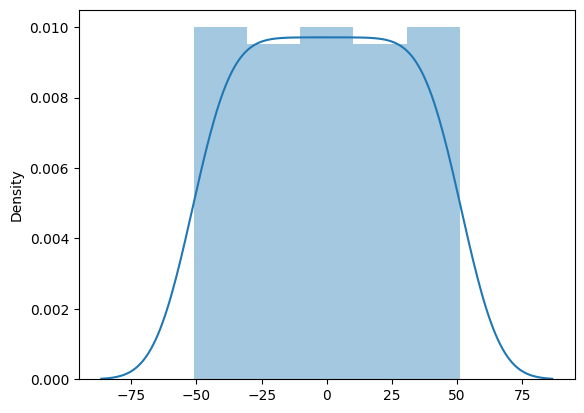

In [24]:
import seaborn as sns
sns.distplot(np.log(alpha_test_ls) / np.log(base))

<Axes: >

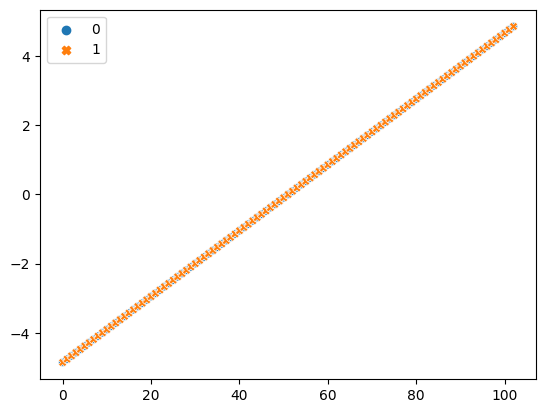

In [25]:
sns.scatterplot([np.log(alpha_test_ls),np.log(alpha_test_ls)])

In [26]:
numvals = 29
alpha_range = np.exp2(np.arange(numvals))/np.power(2,numvals//2)
np.sum(alpha_range > 1) - np.sum(alpha_range < 1)


0

In [32]:

# theoretical numbers
# create combinations of settings meeting the constraints defined in the previous cell




theoretical_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):


    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False #set verbose to True to see which invalid combinations are ignored and why
                                 )

    # enforce each group*label has at least 10 samples
    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            theoretical_full_settings.append(number_setting)
    

## Inspects

In [33]:
len(theoretical_full_settings)

1233

In [36]:
# check number for one setting
# here we can see how the parameters manifest as numbers of examples to be drawn in each set and probabilities
# to guide this sampling procedure
theoretical_full_settings[0]['mix_param_dict']

{'p_pos_train_z0': 0.25,
 'p_pos_train_z1': 0.75,
 'p_pos_train': 0.5,
 'p_pos_test': 0.5,
 'p_mix_z0': 0.5,
 'p_mix_z1': 0.5,
 'alpha_train': 3.0,
 'alpha_test': 0.043056764313424443,
 'p_pos_test_z0': 0.9587205933688893,
 'p_pos_test_z1': 0.041279406631110696,
 'C_y': 0.5,
 'C_z': 0.5}

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.


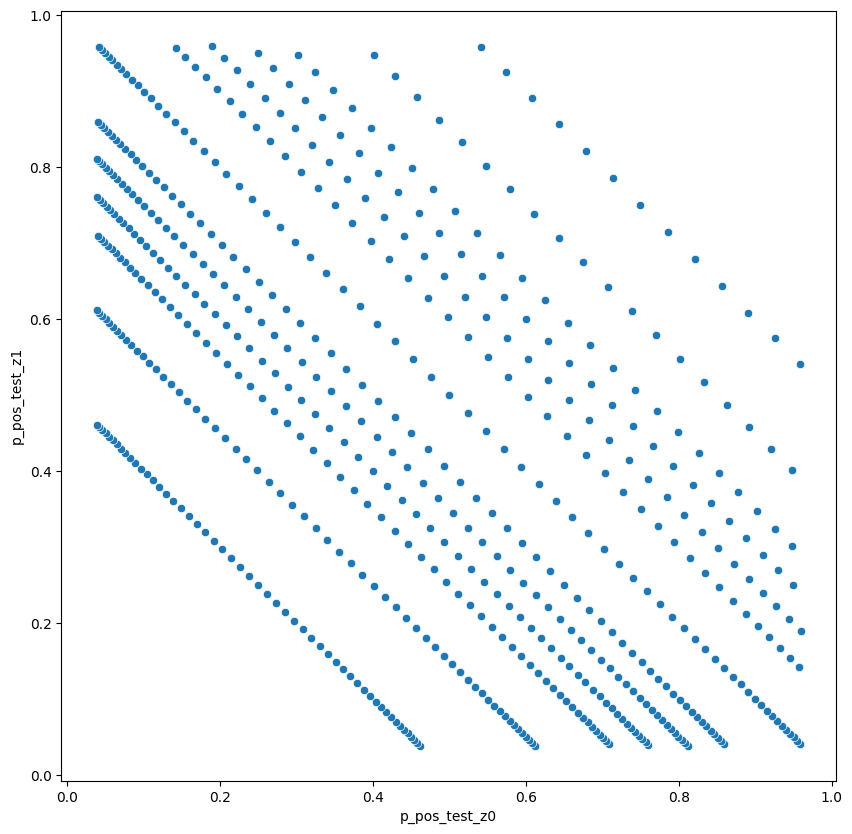

In [38]:
# check distributions of p_pos_test_z0 by p_pos_test_z1
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in theoretical_full_settings])

plt.figure(figsize=(10,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)
print("This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.")

In [39]:
tmp_df.head()

p_pos_train_z0  p_pos_train_z1  p_pos_train  p_pos_test  p_mix_z0  \
0            0.25            0.75          0.5         0.5       0.5   
1            0.25            0.75          0.5         0.5       0.5   
2            0.25            0.75          0.5         0.5       0.5   
3            0.25            0.75          0.5         0.5       0.5   
4            0.25            0.75          0.5         0.5       0.5   

   p_mix_z1  alpha_train  alpha_test  p_pos_test_z0  p_pos_test_z1  C_y  C_z  
0       0.5          3.0    0.043057       0.958721       0.041279  0.5  0.5  
1       0.5          3.0    0.047362       0.954779       0.045221  0.5  0.5  
2       0.5          3.0    0.052099       0.950481       0.049519  0.5  0.5  
3       0.5          3.0    0.057309       0.945798       0.054202  0.5  0.5  
4       0.5          3.0    0.063039       0.940699       0.059301  0.5  0.5

In [40]:
import seaborn as sns

/var/folders/vv/_24hyv6s6ls80lmxgd5b5sr40000gn/T/ipykernel_66489/2144991475.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
/var/folders/vv/_24hyv6s6ls80lmxgd5b5sr40000gn/T/ipykernel_66489/2144991475.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

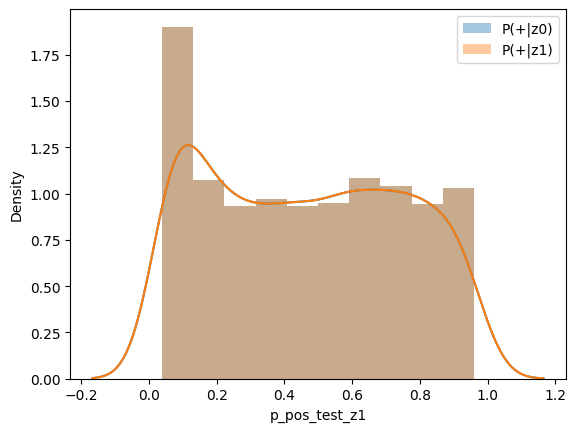

In [41]:
sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
sns.distplot(tmp_df['p_pos_test_z1'],label='P(+|z1)')
plt.legend()

/var/folders/vv/_24hyv6s6ls80lmxgd5b5sr40000gn/T/ipykernel_66489/2144991475.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
/var/folders/vv/_24hyv6s6ls80lmxgd5b5sr40000gn/T/ipykernel_66489/2144991475.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

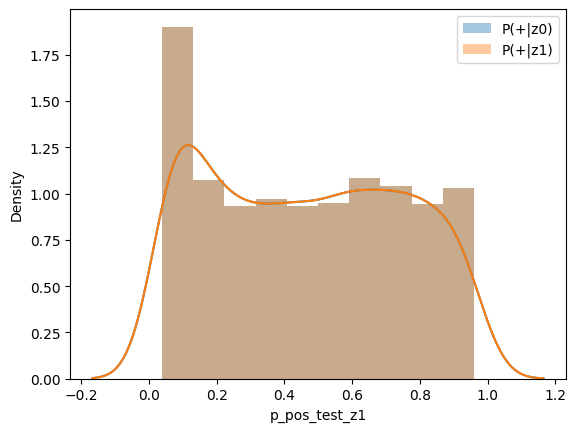

In [42]:
sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
sns.distplot(tmp_df['p_pos_test_z1'],label='P(+|z1)')
plt.legend()

## Split Real Datasets

In [43]:
# To ignore warnings when One Theoretical setting could not apply to the real dataset
import warnings
warnings.filterwarnings('ignore')

In [44]:
dem_lab_df['source1'] = np.ones(len(dem_lab_df))
dem_lab_df['source2'] = np.zeros(len(dem_lab_df))
dem_lab_df.head()

file                                               text  dementia  \
0  257-0  Okay uhhuh. Well the boy's up on the stool. Oh...       1.0   
1  172-0  Okay mother is drying the dishes but the water...       0.0   
2  585-0  Alright. Mama's washing the dishes. The water ...       1.0   
3  137-3  Okay. Little boy is crawling up to get in the ...       0.0   
4  073-3  Okay. Okay. the stool that the the boy was sta...       0.0   

   source1  source2  
0      1.0      0.0  
1      1.0      0.0  
2      1.0      0.0  
3      1.0      0.0  
4      1.0      0.0

In [45]:
wls_lab_df['source1'] = np.zeros(len(wls_lab_df))
wls_lab_df['source2'] = np.ones(len(wls_lab_df))
wls_lab_df.head()

file                                               text  dementia  \
0  2000015784  Well i see a boy taking a cookie outof a cooki...     False   
1  2000015088  The mother's doing dishes. She's naughty. She'...     False   
3  2000015045  Okay. There's a young boy up on a chair that's...     False   
4  2000015213  Kids are in the cookie jar. And the child is r...      True   
6  2000015187  Okay. Everything i see. I see a guy standing o...     False   

   source1  source2  
0      0.0      1.0  
1      0.0      1.0  
3      0.0      1.0  
4      0.0      1.0  
6      0.0      1.0

In [46]:

print("Proportion positive dementia for dementiabank",np.mean(dem_lab_df['dementia']== True))
print("Proportion positive dementia for wls", np.mean(wls_lab_df['dementia']== True))

Proportion positive dementia for dementiabank 0.5565693430656934
Proportion positive dementia for wls 0.21578947368421053


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


label='dementia'
df0 = dem_lab_df
df1 = wls_lab_df


_rand = 252775

acc = []
f1s = []
aps = []
roc = []
alpha_train = []
alpha_test = []
posprev = []

valid_n_full_settings = []
tmp = None
# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=True, #False, 
                     # If True will sample with replacement when dataset lacks enough examples to meet constraints
                     # Sampling one only occur in instances where the actual examples are insufficient
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset (alternatively we could sample with replacement in these instances)
    if dfs is None:
        continue 
    
    

    #########
    ## Computation here
    #########
    
    # do something with dfs
    tmp = dfs
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(tmp['train']['text'].values)
    tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
    train_tfidf = tfidf_transformer.transform(train_counts)

    test_counts = count_vect.transform(tmp['test']['text'].values)
    test_tfidf  = tfidf_transformer.transform(test_counts)

    clf  = MultinomialNB().fit(train_tfidf, tmp['train'][label])
    pred = clf.predict(test_tfidf) 
    prob = clf.predict_proba(test_tfidf)
    pos_prob = [x[1] for x in prob]
    acc.append(np.mean(pred == tmp['test'][label]))
    posprev.append(np.mean(tmp['test'][label]))
    f1s.append(metrics.f1_score(pred, tmp['test'][label], pos_label=True))
    roc.append(metrics.roc_auc_score(tmp['test'][label] == True, pos_prob))
    aps.append(metrics.average_precision_score(tmp['test'][label] == True, pos_prob)) 
    
    valid_n_full_settings.append(c)
    alpha_test.append(c['mix_param_dict']['alpha_test'])
    alpha_train.append(c['mix_param_dict']['alpha_train'])

  0%|          | 0/1233 [00:00<?, ?it/s]

<Axes: ylabel='Density'>

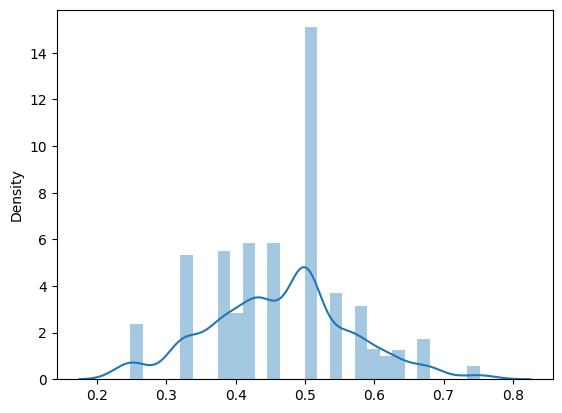

In [51]:
#positive class prevalence in the test set varies - so we can't trust accuracy
sns.distplot(posprev)

In [49]:
valid_n_full_settings

[{'n_train': 2000,
  'n_test': 500,
  'n_z0_pos_train': 250,
  'n_z0_neg_train': 750,
  'n_z0_pos_test': 240,
  'n_z0_neg_test': 10,
  'n_z1_pos_train': 750,
  'n_z1_neg_train': 250,
  'n_z1_pos_test': 10,
  'n_z1_neg_test': 240,
  'mix_param_dict': {'p_pos_train_z0': 0.25,
   'p_pos_train_z1': 0.75,
   'p_pos_train': 0.5,
   'p_pos_test': 0.5,
   'p_mix_z0': 0.5,
   'p_mix_z1': 0.5,
   'alpha_train': 3.0,
   'alpha_test': 0.043056764313424443,
   'p_pos_test_z0': 0.9587205933688893,
   'p_pos_test_z1': 0.041279406631110696,
   'C_y': 0.5,
   'C_z': 0.5}},
 {'n_train': 2000,
  'n_test': 500,
  'n_z0_pos_train': 250,
  'n_z0_neg_train': 750,
  'n_z0_pos_test': 239,
  'n_z0_neg_test': 11,
  'n_z1_pos_train': 750,
  'n_z1_neg_train': 250,
  'n_z1_pos_test': 11,
  'n_z1_neg_test': 239,
  'mix_param_dict': {'p_pos_train_z0': 0.25,
   'p_pos_train_z1': 0.75,
   'p_pos_train': 0.5,
   'p_pos_test': 0.5,
   'p_mix_z0': 0.5,
   'p_mix_z1': 0.5,
   'alpha_train': 3.0,
   'alpha_test': 0.04736244

In [52]:
import seaborn as sns

In [53]:
from scipy import sparse
a = train_tfidf
b = np.zeros([2000,2])
sparse.hstack((sparse.csr_matrix(b), a))

<2000x2386 sparse matrix of type '<class 'numpy.float64'>'
	with 107277 stored elements in Compressed Sparse Row format>

In [54]:
b = sparse.csr_matrix(tmp['train'][['source1','source2']].values)
sparse.hstack([a,b])

<2000x2386 sparse matrix of type '<class 'numpy.float64'>'
	with 109277 stored elements in Compressed Sparse Row format>

In [55]:
sparse.csr_matrix(np.asarray([[1,0]]*10))

<10x2 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [56]:
np.mean(tmp['train'][['source1','source2']],axis=0).values

array([0.5, 0.5])

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import sparse

label='dementia'
df0 = dem_lab_df
df1 = wls_lab_df


_rand = 252775

acc = []
f1s = []
aps = []
roc = []
alpha_train = []
alpha_test = []
valid_n_full_settings = []



tmp = None
# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=True, #True 
                     # If True will sample with replacement when dataset lacks enough examples to meet constraints
                     # Sampling one only occur in instances where the actual examples are insufficient
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset (alternatively we could sample with replacement in these instances)
    if dfs is None:
        continue 
    
    

    #########
    ## Computation here
    #########
    
    # do something with dfs
    tmp = dfs
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(tmp['train']['text'].values)
    tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
    train_tfidf = tfidf_transformer.transform(train_counts)
    
    test_counts = count_vect.transform(tmp['test']['text'].values)
    test_tfidf  = tfidf_transformer.transform(test_counts)
     
    clf  = LogisticRegression(penalty='l1', solver='liblinear',C=0.1).fit(train_tfidf, tmp['train'][label])
    
    pred = clf.predict(test_tfidf) 
    prob = clf.predict_proba(test_tfidf)
    pos_prob = [x[1] for x in prob]
    acc.append(np.mean(pred == tmp['test'][label]))
    f1s.append(metrics.f1_score(pred, tmp['test'][label], pos_label=1.0))
    roc.append(metrics.roc_auc_score(tmp['test'][label] == 1.0, pos_prob))
    aps.append(metrics.average_precision_score(tmp['test'][label] == 1.0, pos_prob)) 
    
    
    valid_n_full_settings.append(c)
    alpha_test.append(c['mix_param_dict']['alpha_test'])
    alpha_train.append(c['mix_param_dict']['alpha_train'])

  0%|          | 0/1233 [00:00<?, ?it/s]

In [57]:
import pandas as pd
rframe = pd.DataFrame(valid_n_full_settings)
rframe['f1s'] = np.asarray(f1s)
rframe['roc'] = np.asarray(roc)
rframe['aps'] = np.asarray(aps)
rframe['acc'] = np.asarray(acc)
rframe['alpha_test'] = np.asarray(alpha_test)

In [58]:
for key in rframe['mix_param_dict'][0].keys():
    rframe[key] = [np.round(x[key],2) for x in rframe['mix_param_dict']]

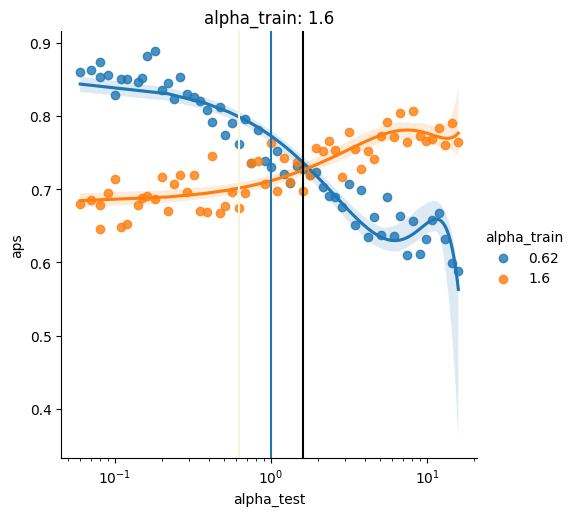

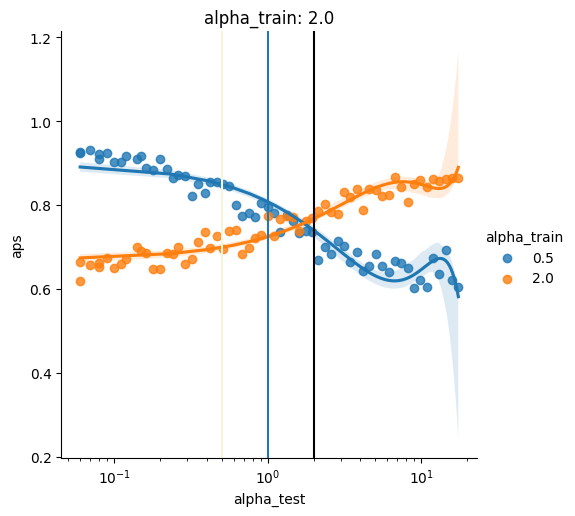

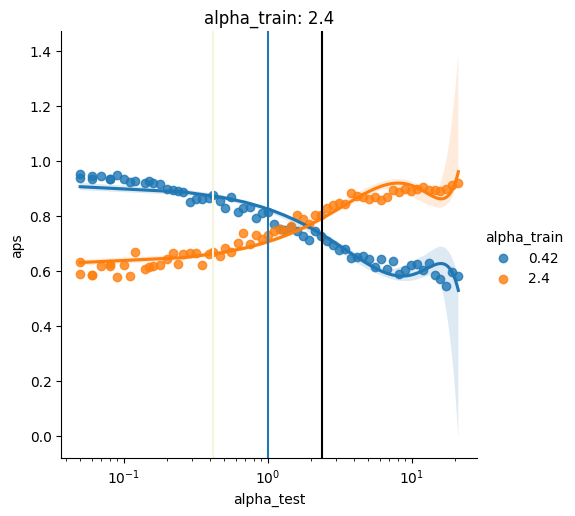

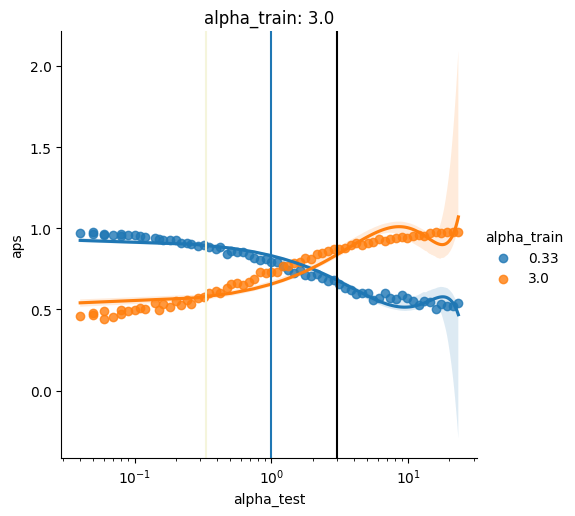

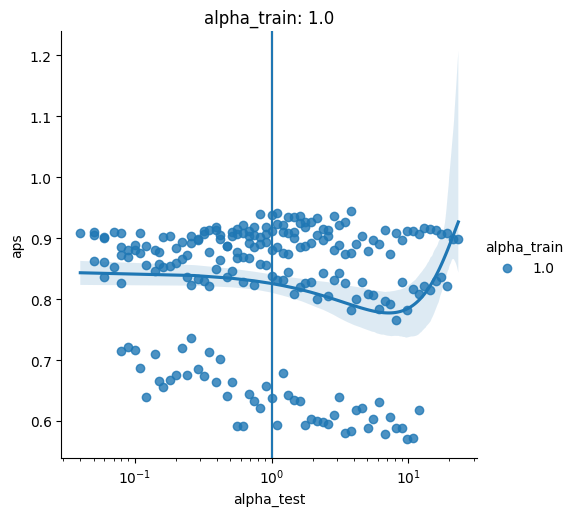

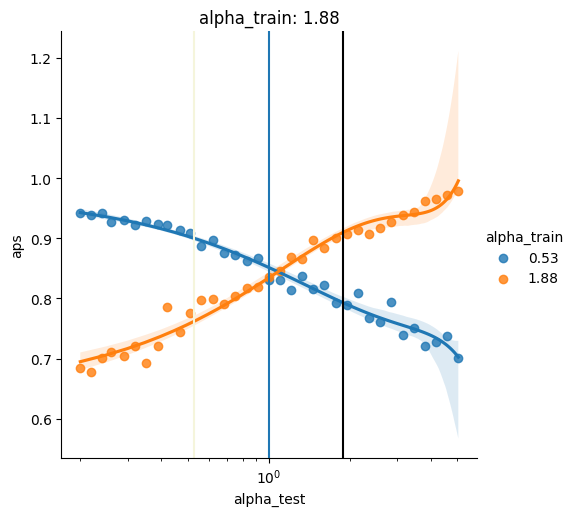

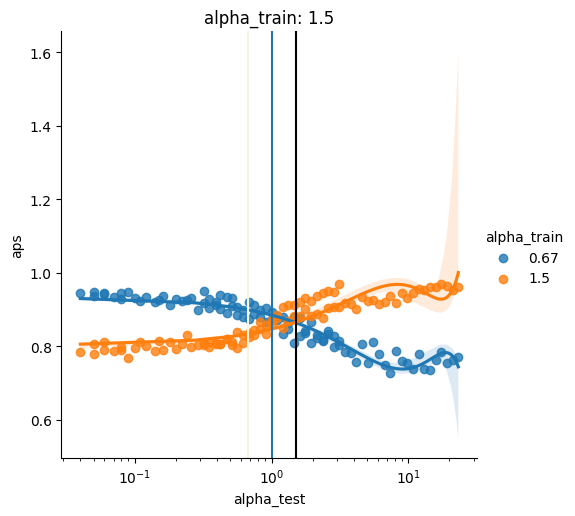

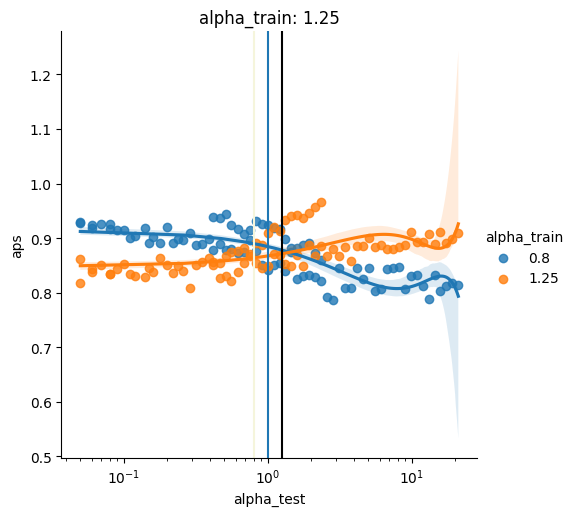

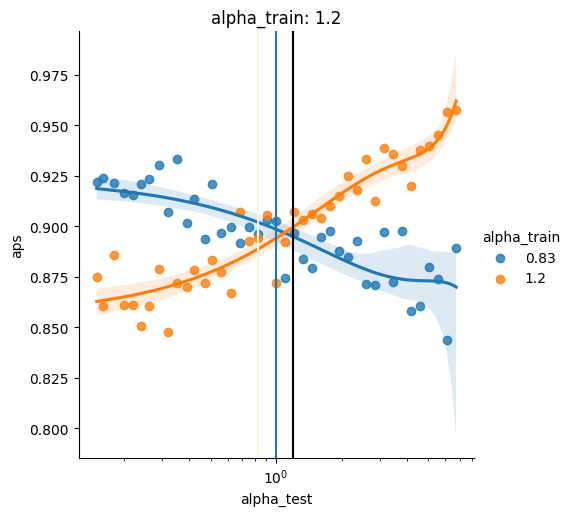

In [59]:
import seaborn as sns
for alpha_train in set(rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.lmplot(data=rframe[(rframe['alpha_train'] == alpha_train) | (rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='aps', hue='alpha_train', order=3)#, style='C_y')#, x_estimator=np.mean)
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        plt.xscale('log')
        plt.axvline(alpha_train,color='black')
        plt.axvline(reciprocal, color='beige')
        plt.axvline(1)
        plt.title('alpha_train: ' + str(alpha_train))
        plt.show()

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import sparse

label='dementia'
df0 = dem_lab_df
df1 = wls_lab_df


_rand = 252775

ba_acc = []
ba_f1s = []
ba_aps = []
ba_roc = []
ba_alpha_train = []
ba_alpha_test = []
ba_valid_n_full_settings = []

gamma = 1

tmp = None
# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=True, #True 
                     # If True will sample with replacement when dataset lacks enough examples to meet constraints
                     # Sampling one only occur in instances where the actual examples are insufficient
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset (alternatively we could sample with replacement in these instances)
    if dfs is None:
        continue 
    
    

    #########
    ## Computation here
    #########
    
    # do something with dfs
    tmp = dfs
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(tmp['train']['text'].values)
    tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
    train_tfidf = tfidf_transformer.transform(train_counts)
    train_tfidf = sparse.hstack([train_tfidf,(sparse.csr_matrix(tmp['train'][['source1','source2']].values*gamma))])
    
    test_counts = count_vect.transform(tmp['test']['text'].values)
    test_tfidf  = tfidf_transformer.transform(test_counts)
    
    train_priors = np.mean(tmp['train'][['source1','source2']],axis=0).values
    
    clf  = LogisticRegression(penalty='l1', solver='liblinear',C=0.1).fit(train_tfidf, tmp['train'][label])
    
    pred = np.zeros(test_tfidf.shape[0])
    prob = [[0,0]] * test_tfidf.shape[0]
    pos_prob = np.zeros(test_tfidf.shape[0])
    
    #multiply each case below by prevalence of training labels
    prevalences = np.mean(tmp['train'][['source1','source2']],axis=0).values
    
    for i,case in enumerate([sparse.csr_matrix( np.asarray([[gamma,0]]*test_tfidf.shape[0] )), sparse.csr_matrix(np.asarray([[0,gamma]]*test_tfidf.shape[0]))]):
        nutest_tfidf = sparse.hstack([test_tfidf,case])
        #pred += clf.predict(nutest_tfidf) 
        aprob = clf.predict_proba(nutest_tfidf)
        for j,x in enumerate(aprob):
            prob[j] += aprob[j] * prevalences[i]
            pos_prob[j] += x[1] * prevalences[i]
        
    pred = pos_prob > 0.5
    
    ba_acc.append(np.mean(pred == tmp['test'][label]))
    ba_f1s.append(metrics.f1_score(pred, tmp['test'][label], pos_label=True))
    ba_roc.append(metrics.roc_auc_score(tmp['test'][label] == 1.0, pos_prob))
    ba_aps.append(metrics.average_precision_score(tmp['test'][label] == 1.0, pos_prob)) 
    
    ba_valid_n_full_settings.append(c)
    ba_alpha_test.append(c['mix_param_dict']['alpha_test'])
    ba_alpha_train.append(c['mix_param_dict']['alpha_train'])

  0%|          | 0/1233 [00:00<?, ?it/s]

In [61]:
import pandas as pd
ba_rframe = pd.DataFrame(ba_valid_n_full_settings)
ba_rframe['f1s'] = np.asarray(ba_f1s)
ba_rframe['roc'] = np.asarray(ba_roc)
ba_rframe['aps'] = np.asarray(ba_aps)
ba_rframe['acc'] = np.asarray(ba_acc)
ba_rframe['alpha_train'] = np.asarray(ba_alpha_train)
ba_rframe['alpha_test'] = np.asarray(ba_alpha_test)

In [62]:
train_tfidf  = tfidf_transformer.transform(train_counts)
source1stack = np.asarray([tmp['train']['source1'].values] * train_tfidf.shape[1])
source2stack = np.asarray([tmp['train']['source1'].values] * train_tfidf.shape[1])
print(train_tfidf.shape)
train_tfidf = sparse.hstack([train_tfidf,train_tfidf.multiply(source1stack.T),train_tfidf.multiply(source2stack.T)])
test_tfidf  = tfidf_transformer.transform(test_counts)
print(train_tfidf.shape)

print(test_tfidf.shape)
source1stack = np.asarray([tmp['test']['source1'].values] * test_tfidf.shape[1])
source2stack = np.asarray([tmp['test']['source1'].values] * test_tfidf.shape[1])
test_tfidf = sparse.hstack([test_tfidf,test_tfidf.multiply(source1stack.T),test_tfidf.multiply(source2stack.T)])
print(test_tfidf.shape)


(2000, 2384)
(2000, 7152)
(500, 2384)
(500, 7152)


In [63]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-mpnet-base-v2')


#tmp['train']['text'].values

In [64]:
dem_lab_df['sbert'] = [model.encode(x) for x in tqdm(dem_lab_df['text'])]

  0%|          | 0/548 [00:00<?, ?it/s]

In [65]:
wls_lab_df['sbert'] = [model.encode(x) for x in tqdm(wls_lab_df['text'])]

  0%|          | 0/760 [00:00<?, ?it/s]

In [66]:
np.asarray(train_tfidf)

array(<2000x7152 sparse matrix of type '<class 'numpy.float64'>'
	with 320118 stored elements in COOrdinate format>, dtype=object)

In [67]:
#SBERT
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy import sparse

label='dementia'
df0 = dem_lab_df
df1 = wls_lab_df


_rand = 252775

#TODO: change these all to aug
sbert_acc = []
sbert_f1s = []
sbert_aps = []
sbert_roc = []
sbert_alpha_train = []
sbert_alpha_test = []
sbert_valid_n_full_settings = []

gamma = 1

tmp = None
# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=True, #True 
                     # If True will sample with replacement when dataset lacks enough examples to meet constraints
                     # Sampling one only occur in instances where the actual examples are insufficient
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset (alternatively we could sample with replacement in these instances)
    if dfs is None:
        continue 
    
    

    #########
    ## Computation here
    #########
    
    # do something with dfs
    tmp = dfs
    count_vect = CountVectorizer()
    train_tfidf = np.vstack(tmp['train']["sbert"])
    #source1stack = np.asarray([tmp['train']['source1'].values] * train_tfidf.shape[1])
    #source2stack = np.asarray([tmp['train']['source2'].values] * train_tfidf.shape[1])
    #train_tfidf = sparse.hstack([train_tfidf,train_tfidf.multiply(source1stack.T),train_tfidf.multiply(source2stack.T)])
    test_tfidf  = np.vstack(tmp['test']["sbert"])
    #source1stack = np.asarray([tmp['test']['source1'].values] * test_tfidf.shape[1])
    #source2stack = np.asarray([tmp['test']['source2'].values] * test_tfidf.shape[1])
    #test_tfidf = sparse.hstack([test_tfidf,test_tfidf.multiply(source1stack.T),test_tfidf.multiply(source2stack.T)])

    
    clf  = LogisticRegression(penalty='l2', solver='liblinear',C=0.1).fit(train_tfidf, tmp['train'][label])
    #clf = RandomForestClassifier().fit(train_tfidf, tmp['train'][label])
    
    pred = clf.predict(test_tfidf) 
    prob = clf.predict_proba(test_tfidf)
    pos_prob = [x[1] for x in prob]
    
    sbert_acc.append(np.mean(pred == tmp['test'][label]))
    sbert_f1s.append(metrics.f1_score(pred, tmp['test'][label], pos_label=1.0))
    sbert_roc.append(metrics.roc_auc_score(tmp['test'][label] == 1.0, pos_prob))
    sbert_aps.append(metrics.average_precision_score(tmp['test'][label] == 1.0, pos_prob)) 
    
    sbert_valid_n_full_settings.append(c)
    sbert_alpha_test.append(c['mix_param_dict']['alpha_test'])
    sbert_alpha_train.append(c['mix_param_dict']['alpha_train'])

  0%|          | 0/1233 [00:00<?, ?it/s]

In [68]:
import pandas as pd
sbert_rframe = pd.DataFrame(sbert_valid_n_full_settings)
sbert_rframe['f1s'] = np.asarray(sbert_f1s)
sbert_rframe['roc'] = np.asarray(sbert_roc)
sbert_rframe['aps'] = np.asarray(sbert_aps)
sbert_rframe['acc'] = np.asarray(sbert_acc)
sbert_rframe['alpha_train'] = np.asarray(sbert_alpha_train)
sbert_rframe['alpha_test'] = np.asarray(sbert_alpha_test)


In [69]:
np.asarray(px1).shape

NameError: name 'px1' is not defined

In [ ]:
lm = LinearRegression()
lm.fit(np.asarray(px1).reshape(-1,1),np.asarray(py1).reshape(-1,1))
round(lm.coef_[0][0],4)

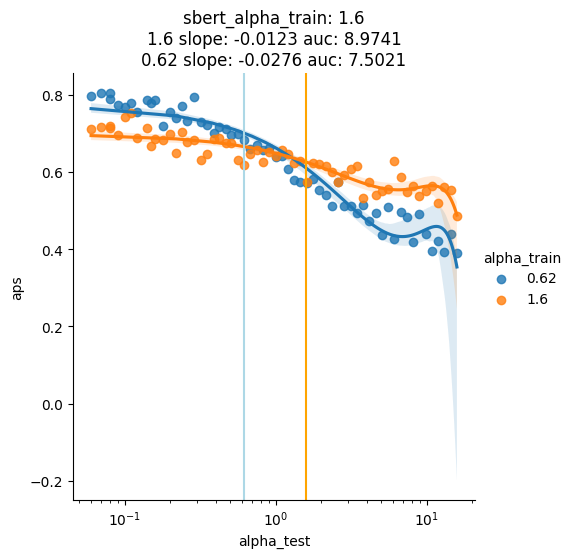

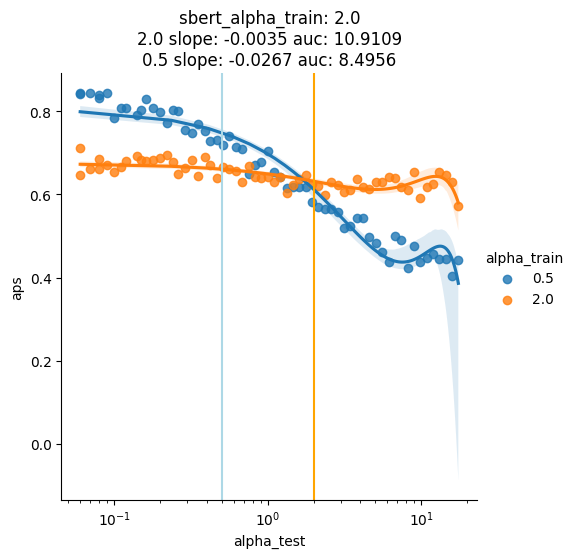

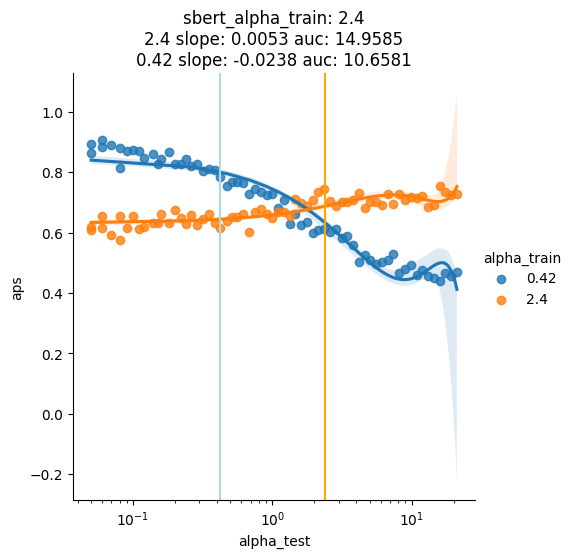

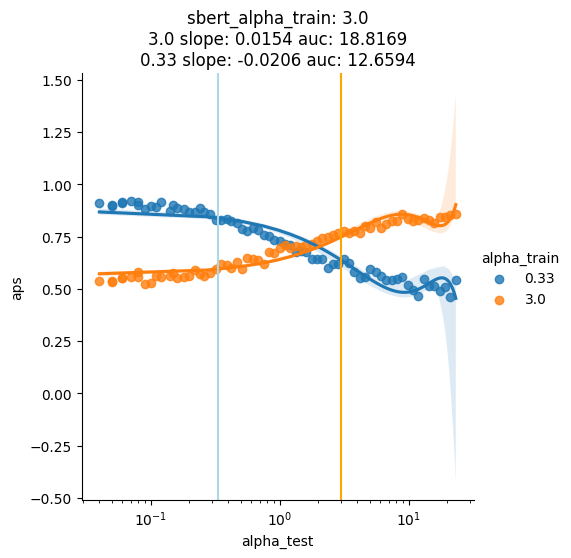

ValueError: x is neither increasing nor decreasing : [ 0.08  0.09  0.1   0.11  0.12  0.14  0.15  0.16  0.18  0.2   0.22  0.24
  0.26  0.29  0.32  0.35  0.39  0.42  0.47  0.51  0.56  0.62  0.68  0.75
  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77  1.95  2.14  2.36
  2.59  2.85  3.14  3.45  3.8   4.18  4.59  5.05  5.56  6.12  6.73  7.4
  8.14  8.95  9.85 10.83 11.92  0.05  0.06  0.06  0.07  0.08  0.08  0.09
  0.1   0.11  0.12  0.14  0.15  0.16  0.18  0.2   0.22  0.24  0.26  0.29
  0.32  0.35  0.39  0.42  0.47  0.51  0.56  0.62  0.68  0.75  0.83  0.91
  1.    1.1   1.21  1.33  1.46  1.61  1.77  1.95  2.14  2.36  2.59  2.85
  3.14  3.45  3.8   4.18  4.59  5.05  5.56  6.12  6.73  7.4   8.14  8.95
  9.85 10.83 11.92 13.11 14.42 15.86 17.45 19.19  0.04  0.05  0.05  0.06
  0.06  0.07  0.08  0.08  0.09  0.1   0.11  0.12  0.14  0.15  0.16  0.18
  0.2   0.22  0.24  0.26  0.29  0.32  0.35  0.39  0.42  0.47  0.51  0.56
  0.62  0.68  0.75  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77
  1.95  2.14  2.36  2.59  2.85  3.14  3.45  3.8   4.18  4.59  5.05  5.56
  6.12  6.73  7.4   8.14  8.95  9.85 10.83 11.92 13.11 14.42 15.86 17.45
 19.19 21.11 23.23  0.26  0.29  0.32  0.35  0.39  0.42  0.47  0.51  0.56
  0.62  0.68  0.75  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77
  1.95  2.14  2.36  2.59  2.85  3.14  3.45  3.8   0.56  0.62  0.68  0.75
  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77].

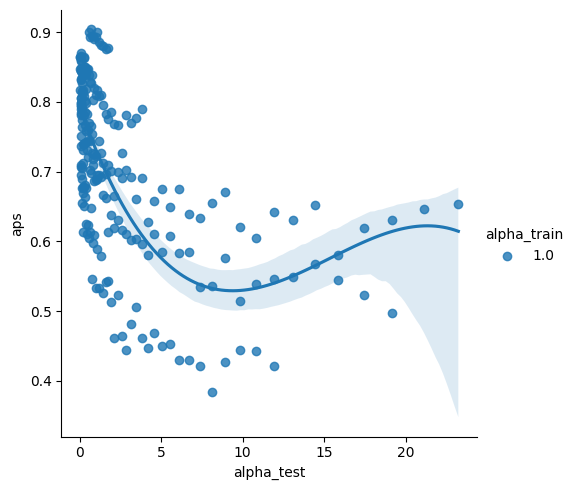

In [328]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc
import seaborn as sns
for key in sbert_rframe['mix_param_dict'][0].keys():
    sbert_rframe[key] = [np.round(x[key],2) for x in sbert_rframe['mix_param_dict']]

for alpha_train in set(sbert_rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.lmplot(data=sbert_rframe[(sbert_rframe['alpha_train'] == alpha_train) | (sbert_rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='aps', hue='alpha_train', order=3)#, style='C_y')#, x_estimator=np.mean)
        
        pdf1 = sbert_rframe[sbert_rframe['alpha_train'] == alpha_train]
        px1 = pdf1["alpha_test"].values
        py1 = pdf1["aps"].values
        
        outstr = ""
        
        lm = LinearRegression()
        lm.fit(np.asarray(px1).reshape(-1,1),np.asarray(py1).reshape(-1,1))
        outstr += "\n"+(str(alpha_train)+" slope: "+str(round(lm.coef_[0][0],4)))
        outstr += " auc: "+ str( round(auc(px1,py1),4) )
        
        pdf2 = sbert_rframe[sbert_rframe['alpha_train'] == reciprocal]
        px2 = pdf2["alpha_test"].values
        py2 = pdf2["aps"].values
        
        lm = LinearRegression()
        lm.fit(np.asarray(px2).reshape(-1,1),np.asarray(py2).reshape(-1,1))
        outstr += "\n"+(str(reciprocal)+" slope: "+str(round(lm.coef_[0][0],4)))
        outstr += " auc: "+ str( round(auc(px2,py2),4) )
        
        
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        plt.xscale('log')
        plt.axvline(alpha_train,color='orange')
        plt.axvline(reciprocal, color='lightblue')
        plt.title('sbert_alpha_train: ' + str(alpha_train) + outstr)
        plt.show()

In [184]:
train_tfidf = np.vstack(tmp['train']["sbert"])
train_tfidf.shape 
#simple permutations
p1 = [x+1 for x in range(train_tfidf.shape[1])]
p1[-1] = 0
pp1 = np.vstack([np.asarray(p1)]*train_tfidf.shape[0])
p2 = [x-1 for x in range(train_tfidf.shape[1])]
p2[0] = 767
pp2 = np.vstack([np.asarray(p1)]*train_tfidf.shape[0])


(2000, 768, 768)

In [199]:
np.vstack([ (x[p1] + x[p2] + x)/3 for x in train_tfidf]).shape

(2000, 768)

In [287]:
x = df0["sbert"][0]
y = 2 * (df0["sbert_perm"][0])  - df0["sbert"][0]
np.dot(x,y) / (np.linalg.norm(x)*np.linalg.norm(y))

-0.05461277546890066

In [275]:
print(df0["sbert"][0][:10])

[-0.02047166 -0.01797956 -0.01363959 -0.02148681 -0.04814221 -0.0006601
 -0.04926713  0.00074216 -0.00892217 -0.05036712]


In [281]:
print(2 * (df0["sbert_perm"][0][:10])  - df0["sbert"][0][:10])

[-0.01797956 -0.01363959 -0.02148681 -0.04814221 -0.0006601  -0.04926713
  0.00074216 -0.00892217 -0.05036712  0.03172572]


In [290]:
np.linalg.norm(df0["sbert"][2])

1.0

In [257]:
#SBERT_AUG
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy import sparse

label='dementia'
df0 = dem_lab_df
df1 = wls_lab_df

# +1 [1,2,3] --> [3,1,2]
# -1 [1,2,3] --> [2,3,1]

source1stack = np.asarray([df0['source1'].values] * 768)
source2stack = np.asarray([df0['source2'].values] * 768)    
df0["sbert_perm"] = [ (x[p1]*source1stack.T[i] + x[p2]*source2stack.T[i] + x)/2 for i,x in enumerate(df0["sbert"])]
df0["test_sbert_perm"] = [ (x[p1] + x[p2] + x)/3 for i,x in enumerate(df0["sbert"])]


source1stack = np.asarray([df1['source1'].values] * 768)
source2stack = np.asarray([df1['source2'].values] * 768)
df1["sbert_perm"] = [ (x[p1]*source1stack.T[i] + x[p2]*source2stack.T[i] + x)/2 for i,x in enumerate(df1["sbert"])]
df1["test_sbert_perm"] = [ (x[p1] + x[p2] + x)/3 for i,x in enumerate(df1["sbert"])]


_rand = 252775

#TODO: change these all to aug
sbert_aug_acc = []
sbert_aug_f1s = []
sbert_aug_aps = []
sbert_aug_roc = []
sbert_aug_alpha_train = []
sbert_aug_alpha_test = []
sbert_aug_valid_n_full_settings = []

gamma = 1

tmp = None
# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=True, #True 
                     # If True will sample with replacement when dataset lacks enough examples to meet constraints
                     # Sampling one only occur in instances where the actual examples are insufficient
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset (alternatively we could sample with replacement in these instances)
    if dfs is None:
        continue 
    
    

    #########
    ## Computation here
    #########
    
    # do something with dfs
    tmp = dfs
    count_vect = CountVectorizer()
    train_tfidf = np.vstack(tmp['train']["sbert_perm"])
    #source1stack = np.asarray([tmp['train']['source1'].values] * train_tfidf.shape[1])
    #source2stack = np.asarray([tmp['train']['source2'].values] * train_tfidf.shape[1])
    #train_tfidf = np.hstack([train_tfidf,np.multiply(train_tfidf,source1stack.T),np.multiply(train_tfidf,source2stack.T)])
   
    test_tfidf  = np.vstack(tmp['test']["test_sbert_perm"])
    #source1stack = np.asarray([tmp['test']['source1'].values] * test_tfidf.shape[1])
    #source2stack = np.asarray([tmp['test']['source2'].values] * test_tfidf.shape[1])
    #test_tfidf = np.hstack([test_tfidf,np.multiply(test_tfidf,source1stack.T),np.multiply(test_tfidf,source2stack.T)])
    
    
    clf  = LogisticRegression(penalty='l2', solver='liblinear',C=0.1).fit(train_tfidf, tmp['train'][label])
    #clf = RandomForestClassifier().fit(train_tfidf, tmp['train'][label])
    
    pred = clf.predict(test_tfidf) 
    prob = clf.predict_proba(test_tfidf)
    pos_prob = [x[1] for x in prob]
    
    sbert_aug_acc.append(np.mean(pred == tmp['test'][label]))
    sbert_aug_f1s.append(metrics.f1_score(pred, tmp['test'][label], pos_label=1.0))
    sbert_aug_roc.append(metrics.roc_auc_score(tmp['test'][label] == 1.0, pos_prob))
    sbert_aug_aps.append(metrics.average_precision_score(tmp['test'][label] == 1.0, pos_prob)) 
    
    sbert_aug_valid_n_full_settings.append(c)
    sbert_aug_alpha_test.append(c['mix_param_dict']['alpha_test'])
    sbert_aug_alpha_train.append(c['mix_param_dict']['alpha_train'])

  0%|          | 0/1233 [00:00<?, ?it/s]

In [206]:

source1stack = np.asarray([tmp['train']['source1'].values] * train_tfidf.shape[1])
atfidf = np.vstack([np.asarray(p1)]*train_tfidf.shape[0])
atfidf*source1stack.T

array([[  1.,   2.,   3., ..., 766., 767.,   0.],
       [  1.,   2.,   3., ..., 766., 767.,   0.],
       [  1.,   2.,   3., ..., 766., 767.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [209]:
df0.head()

file                                               text  dementia  \
0  130-2  Oh well the sink's overflowing. And the lady's...       0.0   
1  061-1  Movement of any kind or whatever. Well he's re...       1.0   
2  209-3  the sink's running over. The water's going all...       0.0   
3  002-3  Okay. It was summertime and mother and the chi...       0.0   
4  109-3  Mhm. there's a boy and a girl and the boy is o...       0.0   

   source1  source2                                              sbert  
0      1.0      0.0  [-0.020471664, -0.01797956, -0.013639588, -0.0...  
1      1.0      0.0  [-0.047012363, -0.023949927, -0.031387392, 0.0...  
2      1.0      0.0  [0.0002590492, -0.0019933113, -0.01776837, -0....  
3      1.0      0.0  [-0.01865693, 0.019685928, -0.010334926, 0.034...  
4      1.0      0.0  [0.006510432, 0.0354437, -0.0111761205, 0.0048...

In [258]:
import pandas as pd
sbert_aug_rframe = pd.DataFrame(sbert_valid_n_full_settings)
sbert_aug_rframe['f1s'] = np.asarray(sbert_aug_f1s)
sbert_aug_rframe['roc'] = np.asarray(sbert_aug_roc)
sbert_aug_rframe['aps'] = np.asarray(sbert_aug_aps)
sbert_aug_rframe['acc'] = np.asarray(sbert_aug_acc)
sbert_aug_rframe['alpha_train'] = np.asarray(sbert_aug_alpha_train)
sbert_aug_rframe['alpha_test'] = np.asarray(sbert_aug_alpha_test)


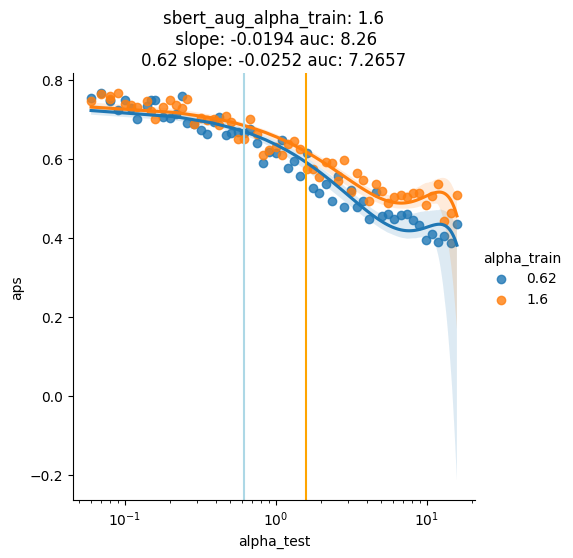

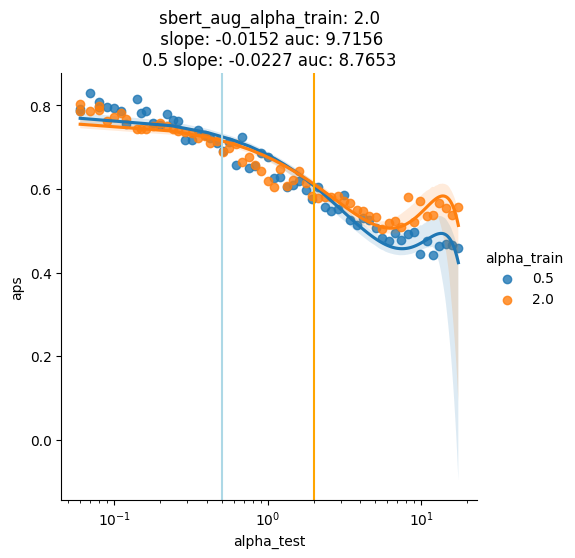

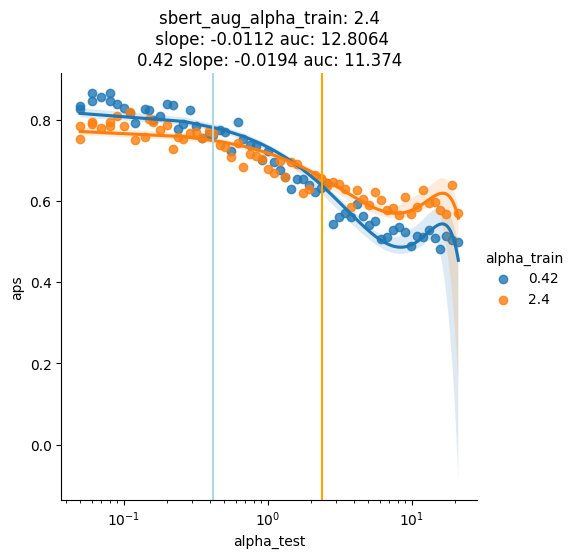

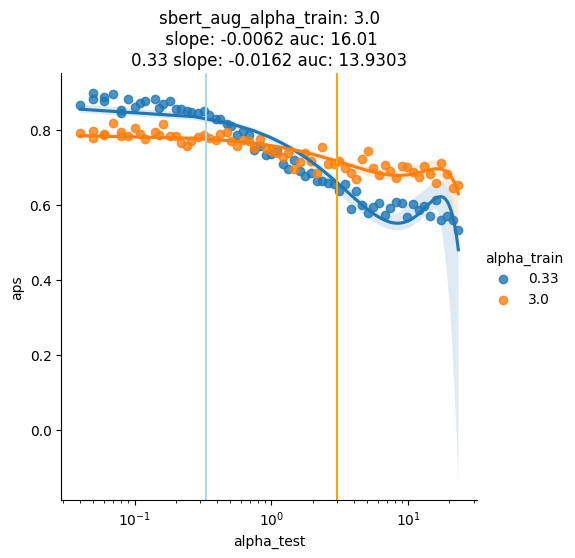

ValueError: x is neither increasing nor decreasing : [ 0.08  0.09  0.1   0.11  0.12  0.14  0.15  0.16  0.18  0.2   0.22  0.24
  0.26  0.29  0.32  0.35  0.39  0.42  0.47  0.51  0.56  0.62  0.68  0.75
  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77  1.95  2.14  2.36
  2.59  2.85  3.14  3.45  3.8   4.18  4.59  5.05  5.56  6.12  6.73  7.4
  8.14  8.95  9.85 10.83 11.92  0.05  0.06  0.06  0.07  0.08  0.08  0.09
  0.1   0.11  0.12  0.14  0.15  0.16  0.18  0.2   0.22  0.24  0.26  0.29
  0.32  0.35  0.39  0.42  0.47  0.51  0.56  0.62  0.68  0.75  0.83  0.91
  1.    1.1   1.21  1.33  1.46  1.61  1.77  1.95  2.14  2.36  2.59  2.85
  3.14  3.45  3.8   4.18  4.59  5.05  5.56  6.12  6.73  7.4   8.14  8.95
  9.85 10.83 11.92 13.11 14.42 15.86 17.45 19.19  0.04  0.05  0.05  0.06
  0.06  0.07  0.08  0.08  0.09  0.1   0.11  0.12  0.14  0.15  0.16  0.18
  0.2   0.22  0.24  0.26  0.29  0.32  0.35  0.39  0.42  0.47  0.51  0.56
  0.62  0.68  0.75  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77
  1.95  2.14  2.36  2.59  2.85  3.14  3.45  3.8   4.18  4.59  5.05  5.56
  6.12  6.73  7.4   8.14  8.95  9.85 10.83 11.92 13.11 14.42 15.86 17.45
 19.19 21.11 23.23  0.26  0.29  0.32  0.35  0.39  0.42  0.47  0.51  0.56
  0.62  0.68  0.75  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77
  1.95  2.14  2.36  2.59  2.85  3.14  3.45  3.8   0.56  0.62  0.68  0.75
  0.83  0.91  1.    1.1   1.21  1.33  1.46  1.61  1.77].

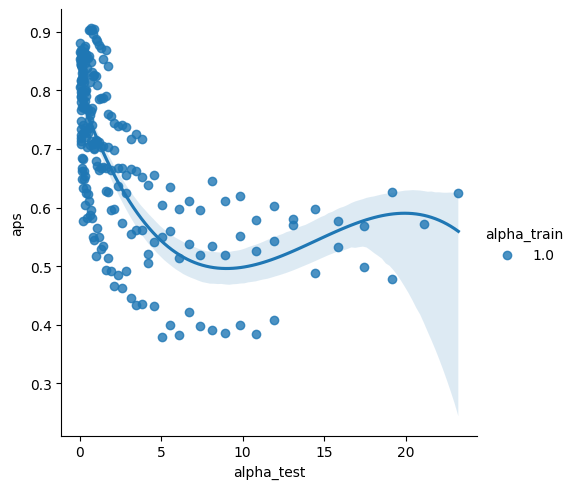

In [333]:
import seaborn as sns
for key in sbert_rframe['mix_param_dict'][0].keys():
    sbert_aug_rframe[key] = [np.round(x[key],2) for x in sbert_aug_rframe['mix_param_dict']]

for alpha_train in set(sbert_aug_rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.lmplot(data=sbert_aug_rframe[(sbert_aug_rframe['alpha_train'] == alpha_train) | (sbert_aug_rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='aps', hue='alpha_train', order=3)#, style='C_y')#, x_estimator=np.mean)
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        pdf1 = sbert_aug_rframe[sbert_aug_rframe['alpha_train'] == alpha_train]
        px1 = pdf1["alpha_test"].values
        py1 = pdf1["aps"].values
        
        outstr = ""
        
      
        lm = LinearRegression()
        lm.fit(np.asarray(px1).reshape(-1,1),np.asarray(py1).reshape(-1,1))
        outstr += "\n"+" slope: "+str(round(lm.coef_[0][0],4))
        outstr += " auc: "+ str( round(auc(px1,py1),4) )

        pdf2 = sbert_aug_rframe[sbert_aug_rframe['alpha_train'] == reciprocal]
        px2 = pdf2["alpha_test"].values
        py2 = pdf2["aps"].values

        lm = LinearRegression()
        lm.fit(np.asarray(px2).reshape(-1,1),np.asarray(py2).reshape(-1,1))
        outstr += "\n"+(str(reciprocal)+" slope: "+str(round(lm.coef_[0][0],4)))
        outstr += " auc: "+ str( round(auc(px2,py2),4) )
        
        
        plt.xscale('log')
        plt.axvline(alpha_train,color='orange')
        plt.axvline(reciprocal, color='lightblue')
        #plt.axvline(1)
        plt.title('sbert_aug_alpha_train: ' + str(alpha_train)+ outstr)
        plt.show()

# SBERT_AUG
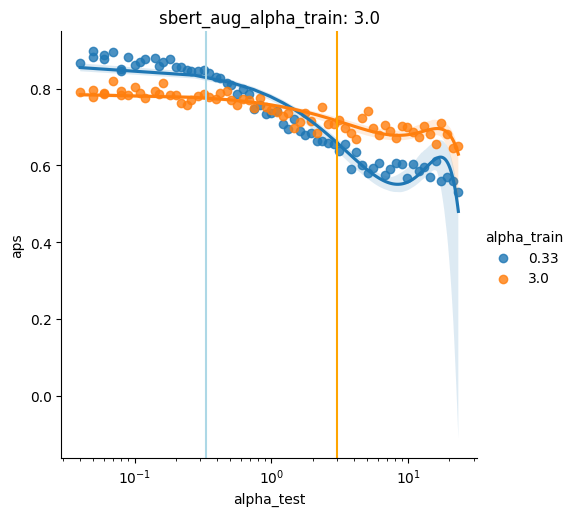
# SBERT
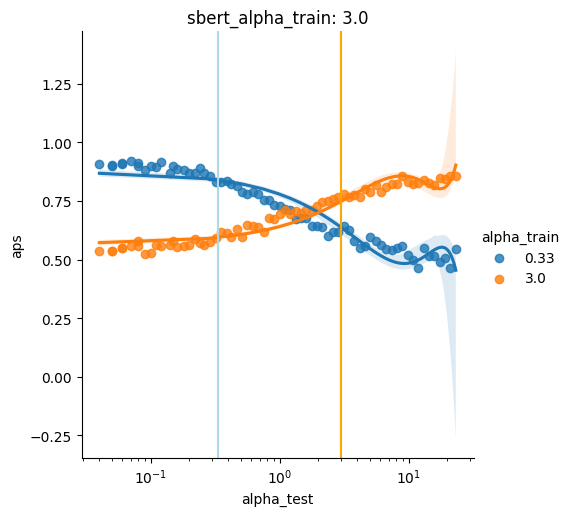

In [138]:
train_counts = count_vect.fit_transform(tmp['train']['text'].values)
tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
train_tfidf = tfidf_transformer.transform(train_counts)
    
train_tfidf.shape
source1stack = np.asarray([tmp['train']['source1'].values] * train_tfidf.shape[1]).T
source2stack = np.asarray([tmp['train']['source2'].values] * train_tfidf.shape[1]).T
    
sparse.hstack([train_tfidf,train_tfidf.multiply(source1stack),train_tfidf.multiply(source2stack)])

<2000x6120 sparse matrix of type '<class 'numpy.float64'>'
	with 322827 stored elements in COOrdinate format>

In [139]:
#AUGMENT
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy import sparse

label='dementia'
df0 = dem_lab_df
df1 = wls_lab_df


_rand = 252775

#TODO: change these all to aug
aug_acc = []
aug_f1s = []
aug_aps = []
aug_roc = []
aug_alpha_train = []
aug_alpha_test = []
aug_valid_n_full_settings = []

gamma = 1

tmp = None
# iterate over theoretical settings
for c in tqdm(theoretical_full_settings):
    c = c.copy()
    dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=True, #True 
                     # If True will sample with replacement when dataset lacks enough examples to meet constraints
                     # Sampling one only occur in instances where the actual examples are insufficient
                     seed=_rand,
                    )

    # one theoretical setting doesn't apply to real dataset (alternatively we could sample with replacement in these instances)
    if dfs is None:
        continue 
    
    

    #########
    ## Computation here
    #########
    
    # do something with dfs
    tmp = dfs
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(tmp['train']['text'].values)
    tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
    train_tfidf = tfidf_transformer.transform(train_counts)
    source1stack = np.asarray([tmp['train']['source1'].values] * train_tfidf.shape[1])
    source2stack = np.asarray([tmp['train']['source2'].values] * train_tfidf.shape[1])
    train_tfidf = sparse.hstack([train_tfidf,train_tfidf.multiply(source1stack.T),train_tfidf.multiply(source2stack.T)])
    test_counts = count_vect.transform(tmp['test']['text'].values)
    test_tfidf  = tfidf_transformer.transform(test_counts)
    source1stack = np.asarray([tmp['test']['source1'].values] * test_tfidf.shape[1])
    source2stack = np.asarray([tmp['test']['source2'].values] * test_tfidf.shape[1])
    test_tfidf = sparse.hstack([test_tfidf,test_tfidf.multiply(source1stack.T),test_tfidf.multiply(source2stack.T)])

    
    clf  = LogisticRegression(penalty='l2', solver='liblinear',C=0.1).fit(train_tfidf, tmp['train'][label])
    #clf = RandomForestClassifier().fit(train_tfidf, tmp['train'][label])
    
    pred = clf.predict(test_tfidf) 
    prob = clf.predict_proba(test_tfidf)
    pos_prob = [x[1] for x in prob]
    
    aug_acc.append(np.mean(pred == tmp['test'][label]))
    aug_f1s.append(metrics.f1_score(pred, tmp['test'][label], pos_label=1.0))
    aug_roc.append(metrics.roc_auc_score(tmp['test'][label] == 1.0, pos_prob))
    aug_aps.append(metrics.average_precision_score(tmp['test'][label] == 1.0, pos_prob)) 
    
    aug_valid_n_full_settings.append(c)
    aug_alpha_test.append(c['mix_param_dict']['alpha_test'])
    aug_alpha_train.append(c['mix_param_dict']['alpha_train'])

  0%|          | 0/1233 [00:00<?, ?it/s]

In [140]:
import pandas as pd
aug_rframe = pd.DataFrame(aug_valid_n_full_settings)
aug_rframe['f1s'] = np.asarray(aug_f1s)
aug_rframe['roc'] = np.asarray(aug_roc)
aug_rframe['aps'] = np.asarray(aug_aps)
aug_rframe['acc'] = np.asarray(aug_acc)
aug_rframe['alpha_train'] = np.asarray(aug_alpha_train)
aug_rframe['alpha_test'] = np.asarray(aug_alpha_test)


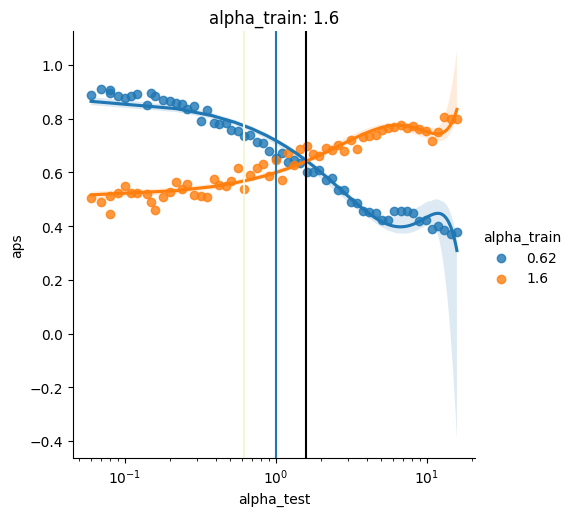

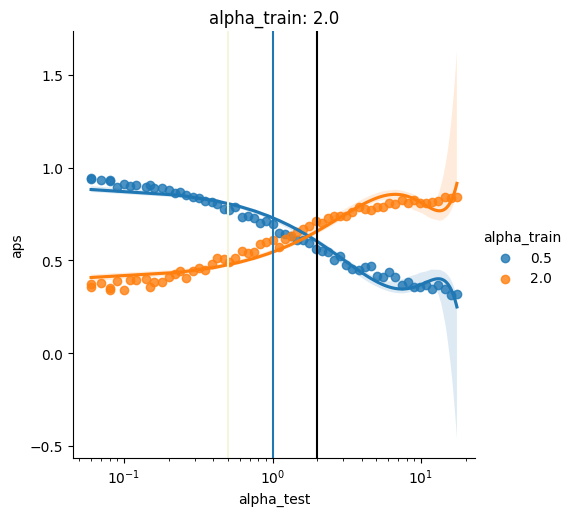

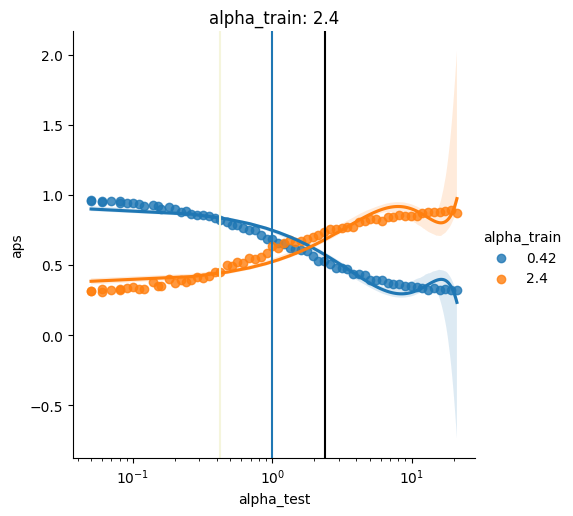

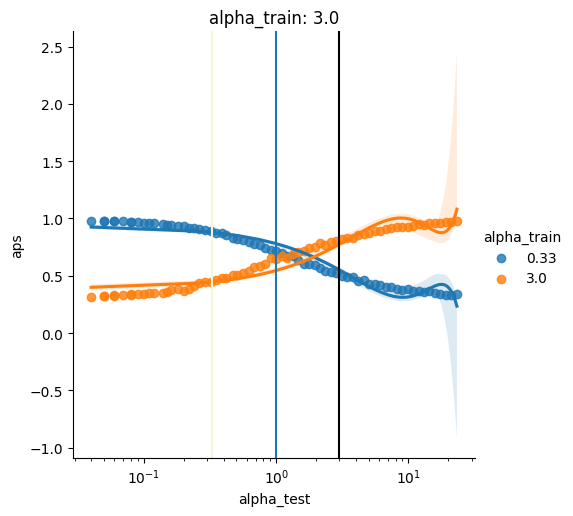

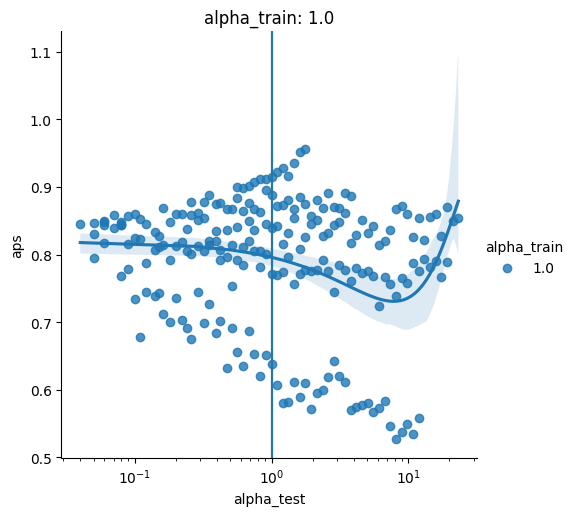

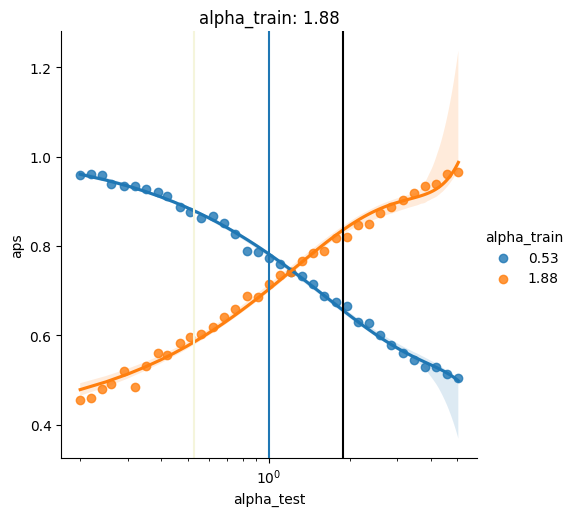

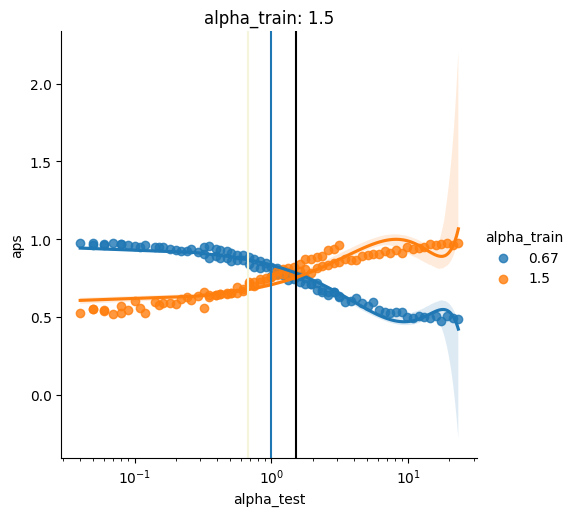

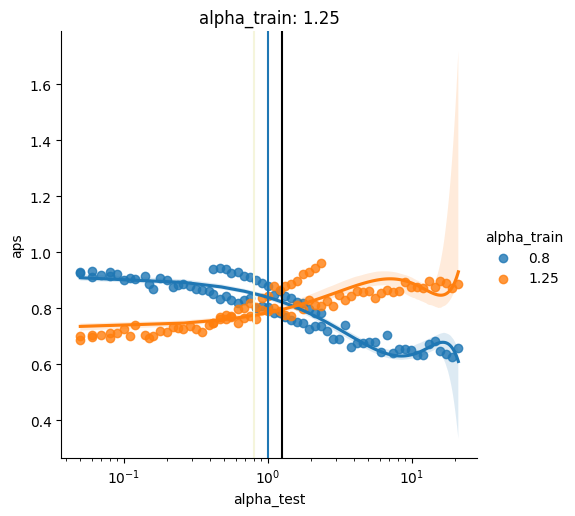

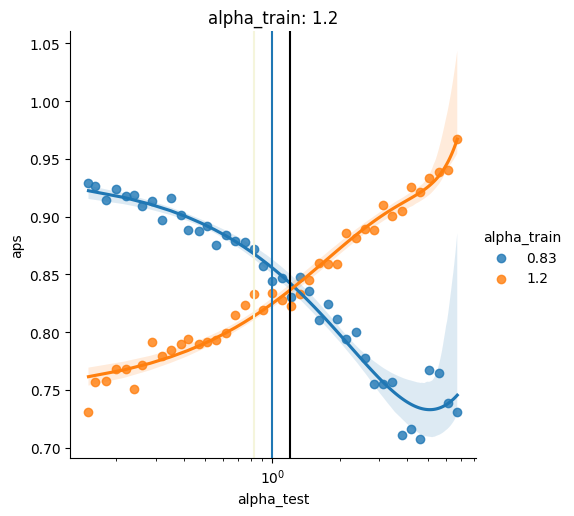

In [141]:
for key in aug_rframe['mix_param_dict'][0].keys():
    aug_rframe[key] = [np.round(x[key],2) for x in aug_rframe['mix_param_dict']]

import seaborn as sns
for alpha_train in set(aug_rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.lmplot(data=aug_rframe[(aug_rframe['alpha_train'] == alpha_train) | (aug_rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='aps', hue='alpha_train', order=3)#, style='C_y')#, x_estimator=np.mean)
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        plt.xscale('log')
        plt.axvline(alpha_train,color='black')
        plt.axvline(reciprocal, color='beige')
        plt.axvline(1)
        plt.title('alpha_train: ' + str(alpha_train))
        plt.show()


In [48]:
nutest_tfidf.toarray()[0][-10:]

array([0.        , 0.05671419, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ])

In [49]:
#valid_n_full_settings

In [50]:
ba_rframe.keys()

Index(['n_train', 'n_test', 'n_z0_pos_train', 'n_z0_neg_train',
       'n_z0_pos_test', 'n_z0_neg_test', 'n_z1_pos_train', 'n_z1_neg_train',
       'n_z1_pos_test', 'n_z1_neg_test', 'mix_param_dict', 'f1s', 'roc', 'aps',
       'acc', 'alpha_train', 'alpha_test'],
      dtype='object')

In [51]:
for key in ba_rframe['mix_param_dict'][0].keys():
    ba_rframe[key] = [np.round(x[key],2) for x in ba_rframe['mix_param_dict']]

In [52]:
for key in aug_rframe['mix_param_dict'][0].keys():
    aug_rframe[key] = [np.round(x[key],2) for x in aug_rframe['mix_param_dict']]

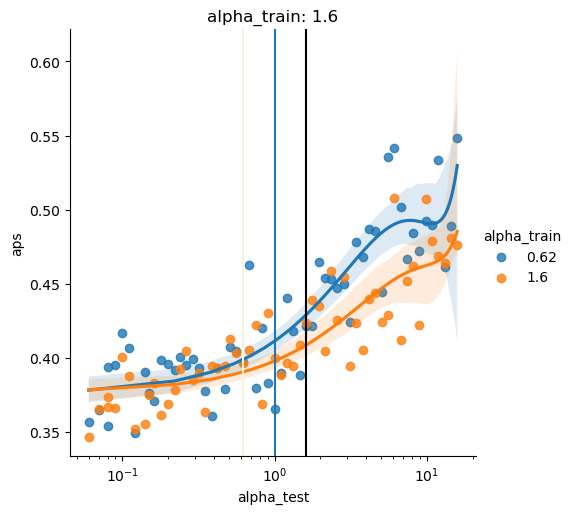

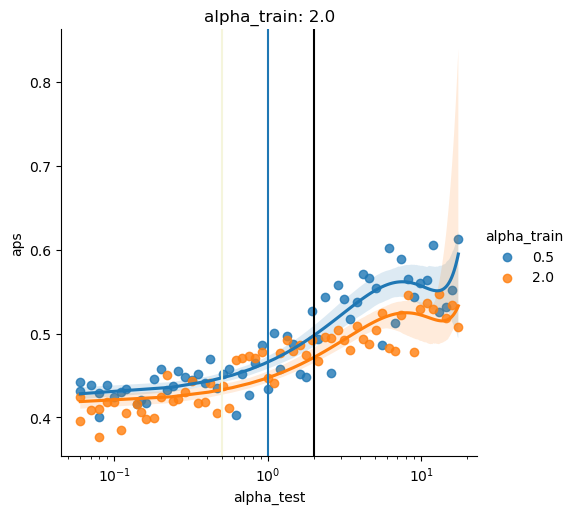

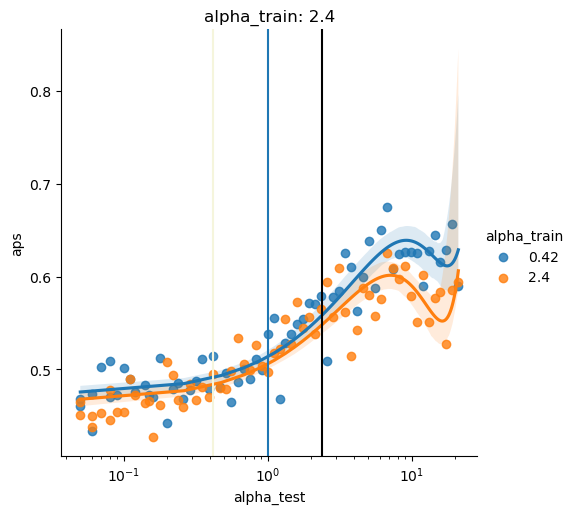

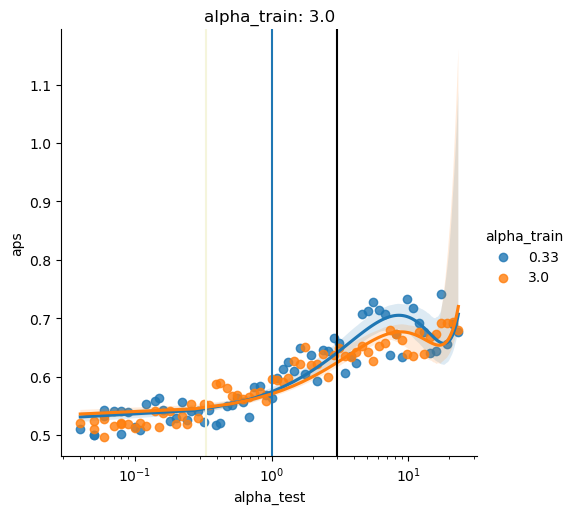

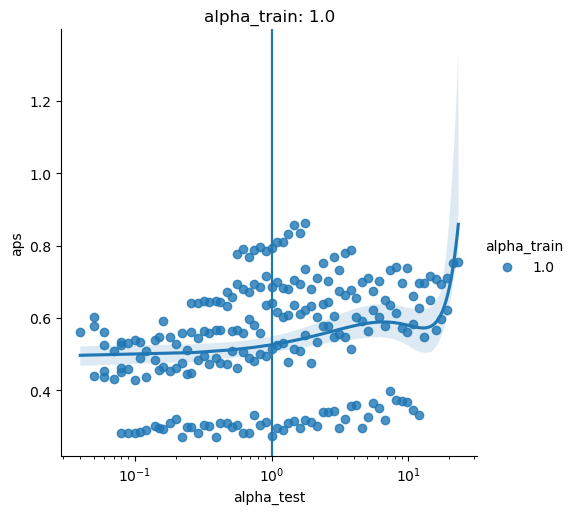

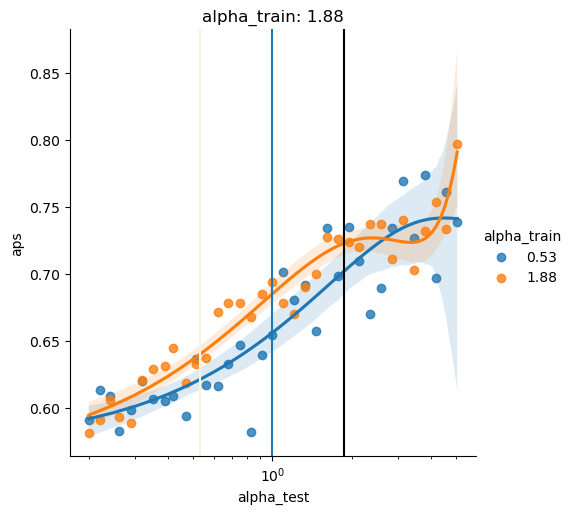

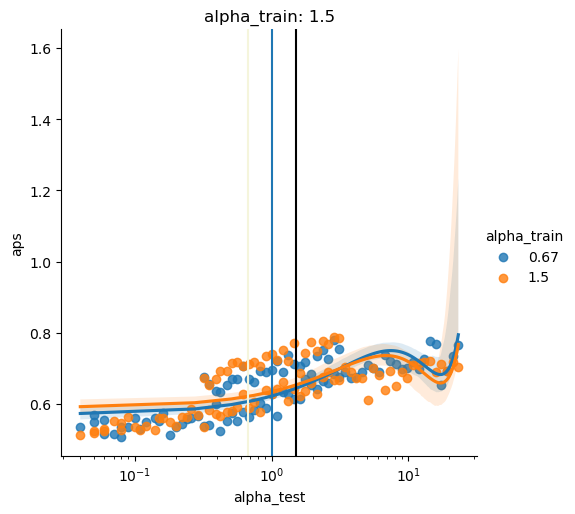

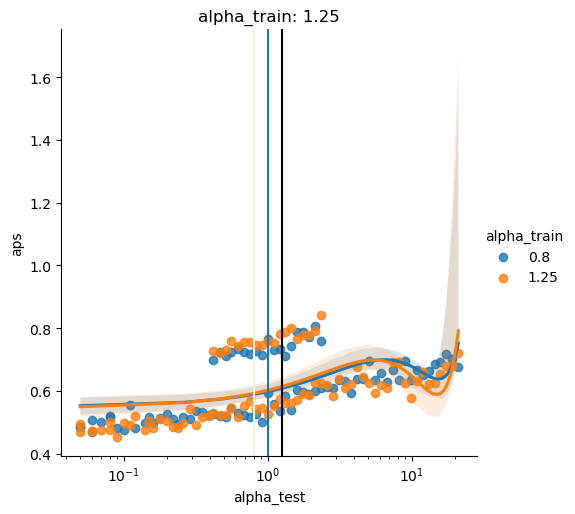

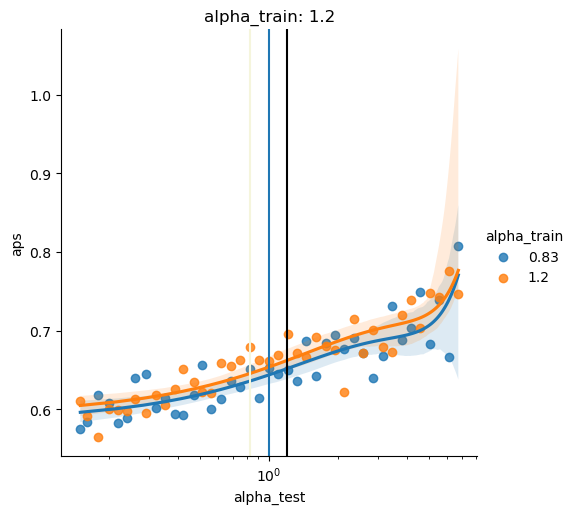

In [53]:
import seaborn as sns
for alpha_train in set(ba_rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.lmplot(data=ba_rframe[(ba_rframe['alpha_train'] == alpha_train) | (ba_rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='aps', hue='alpha_train', order=3)#, style='C_y')#, x_estimator=np.mean)
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        plt.xscale('log')
        plt.axvline(alpha_train,color='black')
        plt.axvline(reciprocal, color='beige')
        plt.axvline(1)
        plt.title('alpha_train: ' + str(alpha_train))
        plt.show()

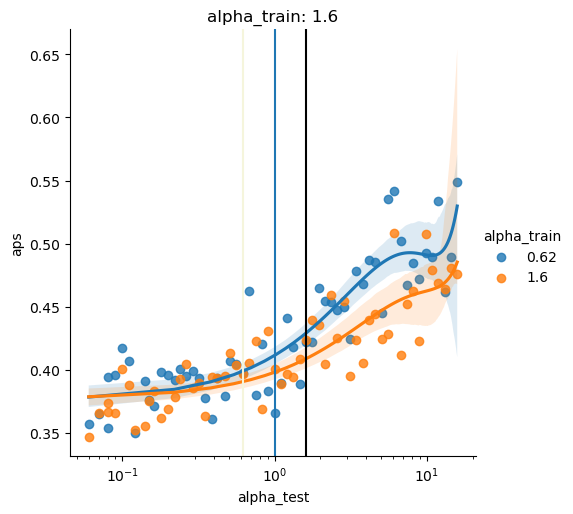

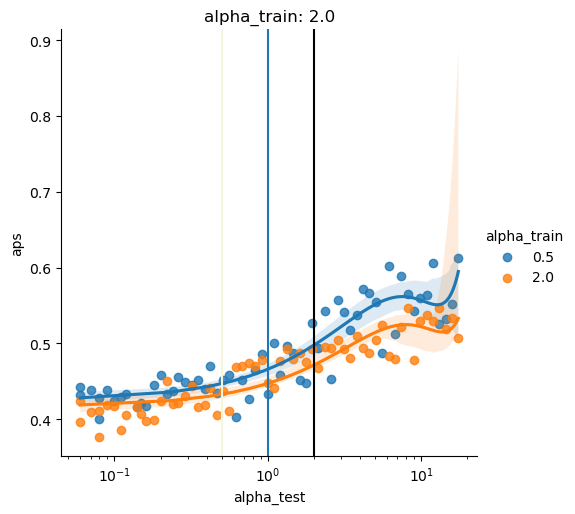

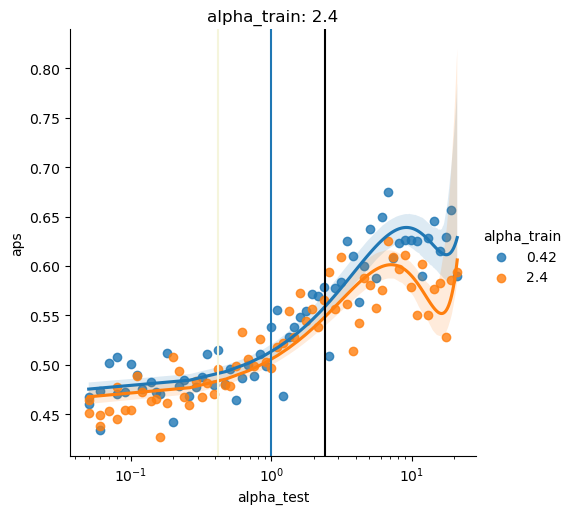

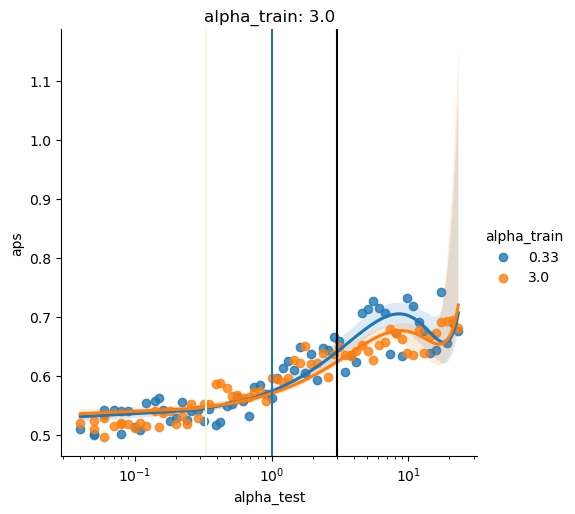

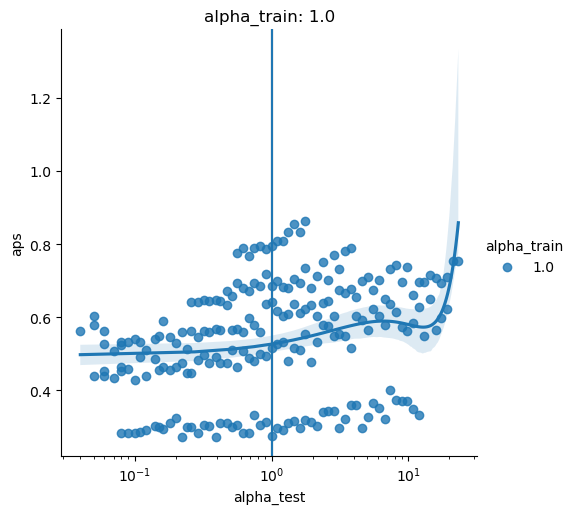

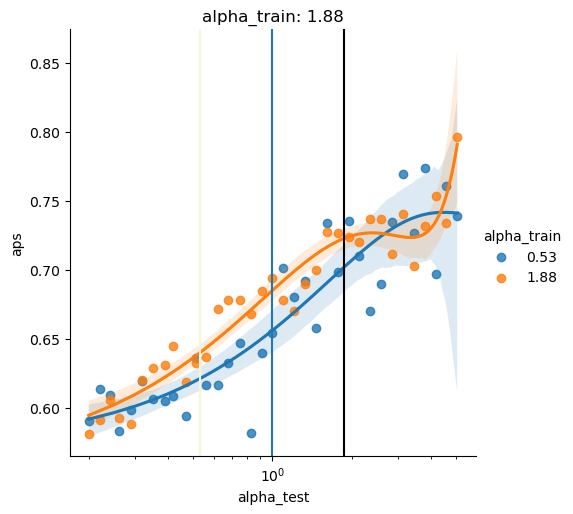

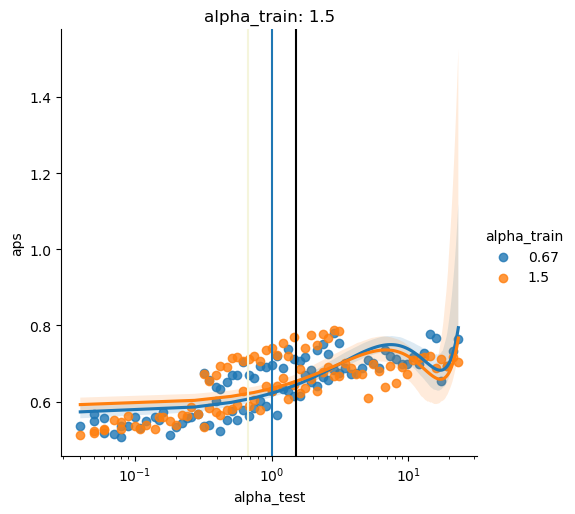

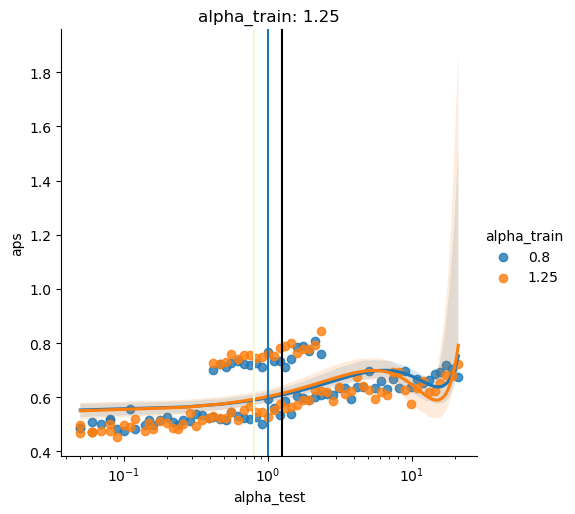

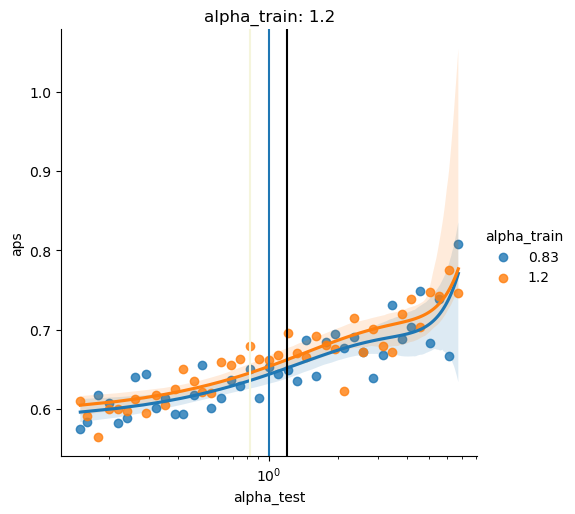

In [54]:
import seaborn as sns
for alpha_train in set(aug_rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.lmplot(data=ba_rframe[(aug_rframe['alpha_train'] == alpha_train) | (aug_rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='aps', hue='alpha_train', order=3)#, style='C_y')#, x_estimator=np.mean)
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        plt.xscale('log')
        plt.axvline(alpha_train,color='black')
        plt.axvline(reciprocal, color='beige')
        plt.axvline(1)
        plt.title('alpha_train: ' + str(alpha_train))
        plt.show()

WITHOUT ADJUSTMENT:
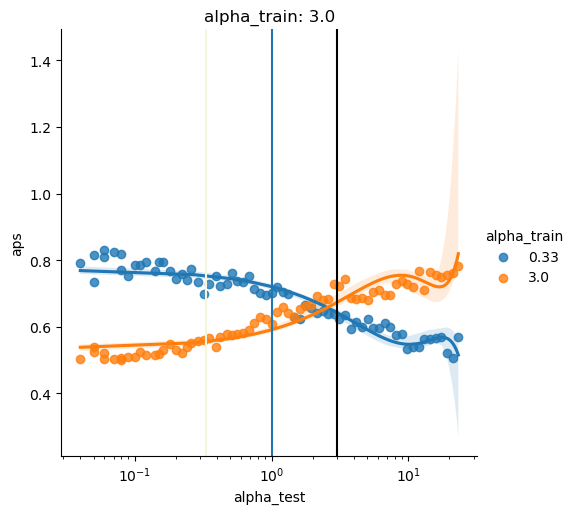

WITH ADJUSTMENT
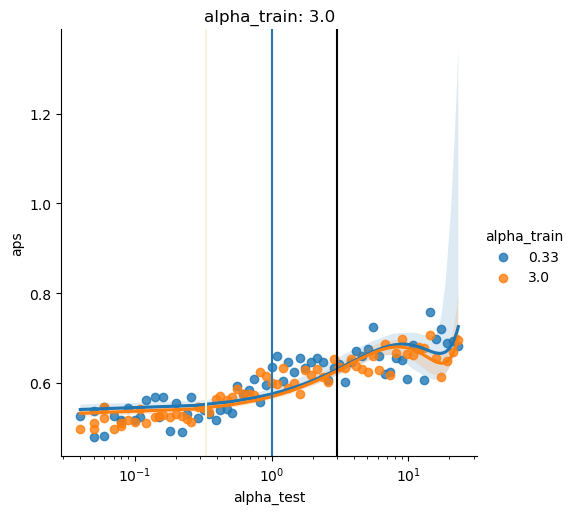

WITH AUGMENTATION
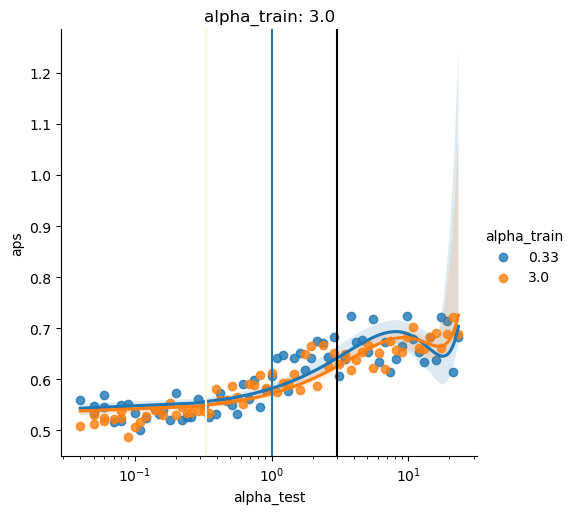

In [73]:
import pandas as pd
rframe = pd.DataFrame(valid_n_full_settings)
rframe['f1s'] = np.asarray(f1s)
rframe['roc'] = np.asarray(roc)
rframe['aps'] = np.asarray(aps)
rframe['acc'] = np.asarray(acc)
rframe['alpha_train'] = np.asarray(alpha_train)
rframe['alpha_test'] = np.asarray(alpha_test)

In [74]:
for key in rframe['mix_param_dict'][0].keys():
    rframe[key] = [np.round(x[key],2) for x in rframe['mix_param_dict']]

In [75]:
set(rframe['p_pos_train_z0'])

{0.25, 0.4, 0.5, 0.6, 0.75}

In [76]:
set(rframe['alpha_train'])

{0.33,
 0.42,
 0.5,
 0.53,
 0.62,
 0.67,
 0.8,
 0.83,
 1.0,
 1.2,
 1.25,
 1.5,
 1.6,
 1.88,
 2.0,
 2.4,
 3.0}

In [77]:
rframe['mix_param_dict'][0]

{'p_pos_train_z0': 0.25,
 'p_pos_train_z1': 0.75,
 'p_pos_train': 0.5,
 'p_pos_test': 0.5,
 'p_mix_z0': 0.5,
 'p_mix_z1': 0.5,
 'alpha_train': 3.0,
 'alpha_test': 0.043056764313424443,
 'p_pos_test_z0': 0.9587205933688893,
 'p_pos_test_z1': 0.041279406631110696,
 'C_y': 0.5,
 'C_z': 0.5}

In [78]:
for key in rframe['mix_param_dict'][0].keys():
    print(key,np.std(rframe[key]))

p_pos_train_z0 0.1625511534636771
p_pos_train_z1 0.16255115346367507
p_pos_train 0.1014361038094009
p_pos_test 0.1014361038094009
p_mix_z0 0.0
p_mix_z1 0.0
alpha_train 0.6934512217892147
alpha_test 4.524252989370812
p_pos_test_z0 0.28395452573303465
p_pos_test_z1 0.2839545257330347
C_y 0.1014361038094009
C_z 0.0


<Axes: xlabel='C_y', ylabel='Density'>

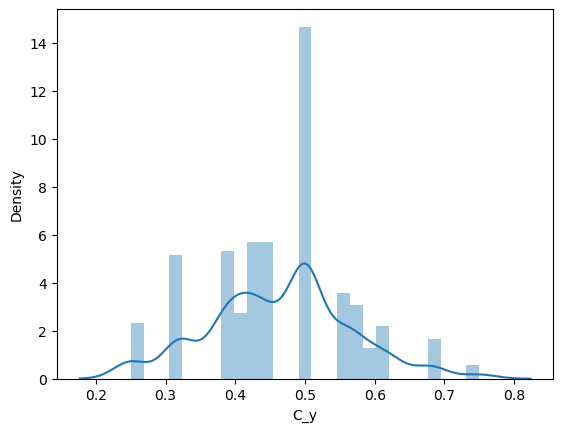

In [79]:
sns.distplot(rframe['C_y'])

In [80]:
#C_y : overall positive rate in train and test
#C_z : currently always 0.5

In [81]:
set(rframe['alpha_train'])

{0.33,
 0.42,
 0.5,
 0.53,
 0.62,
 0.67,
 0.8,
 0.83,
 1.0,
 1.2,
 1.25,
 1.5,
 1.6,
 1.88,
 2.0,
 2.4,
 3.0}

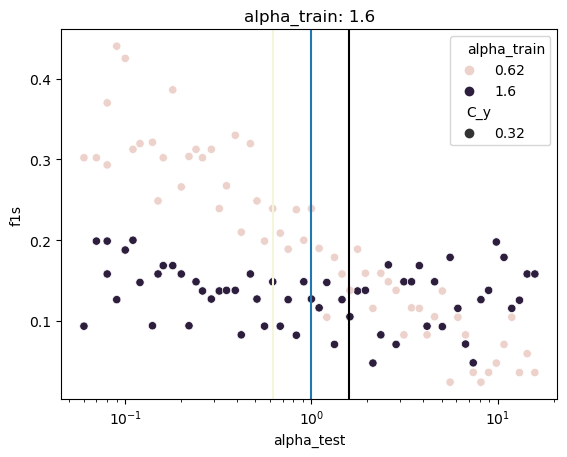

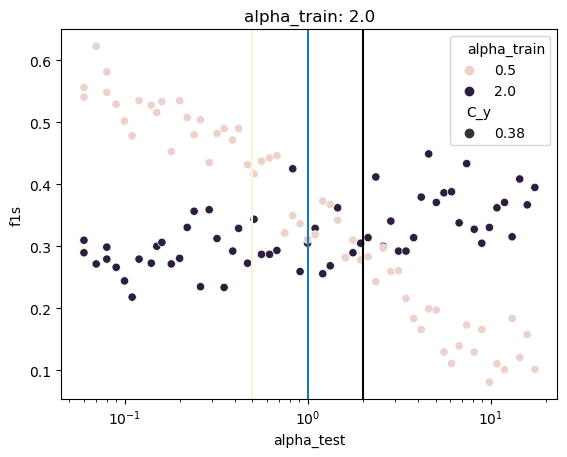

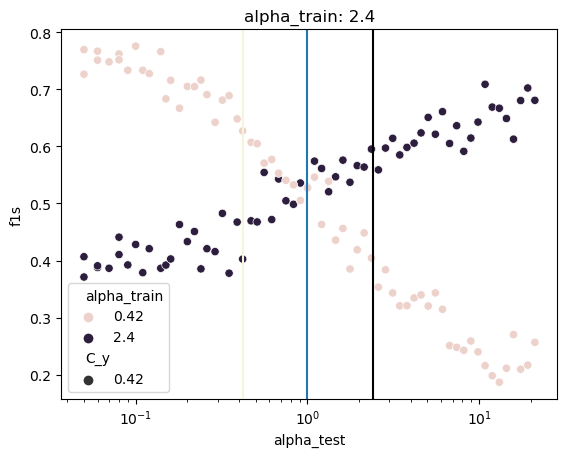

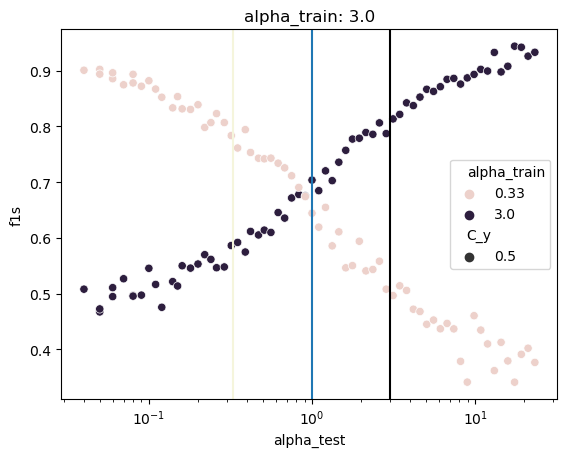

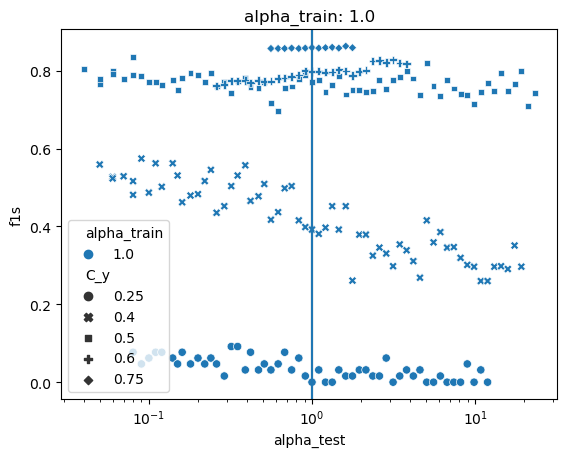

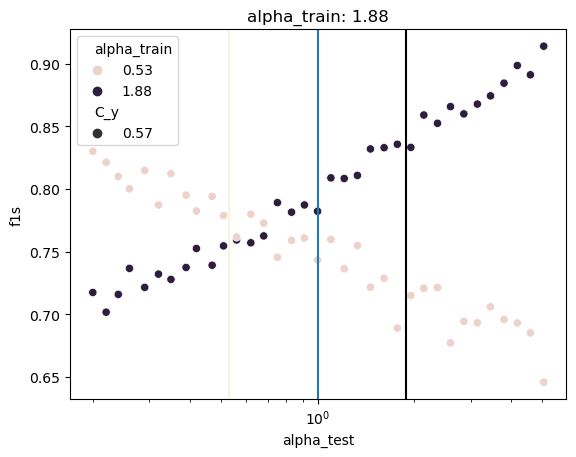

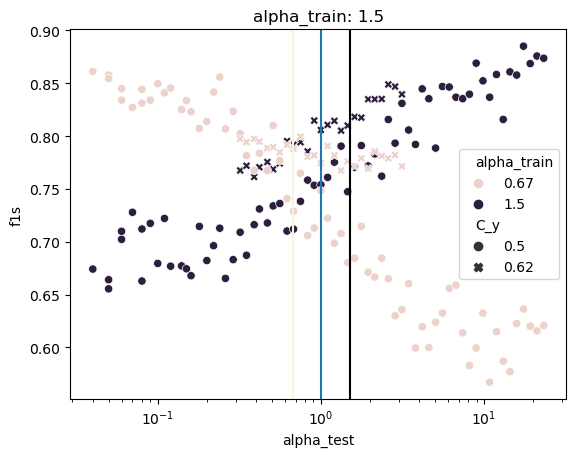

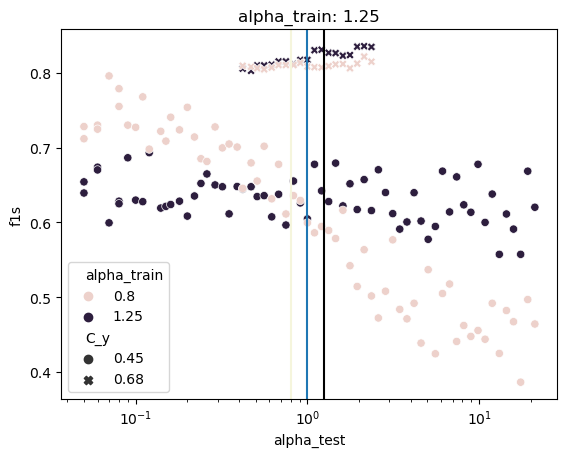

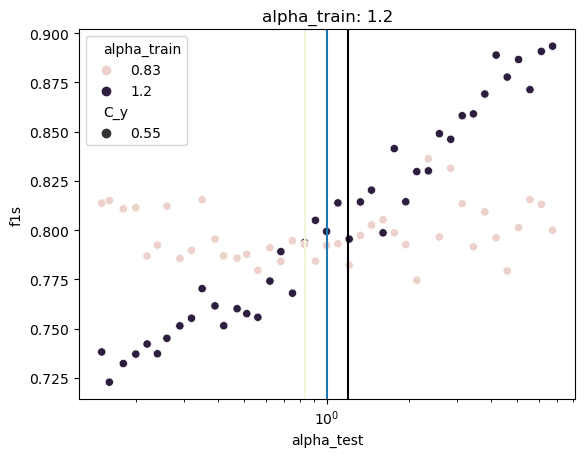

In [82]:
import seaborn as sns
for alpha_train in set(rframe['alpha_train']):
    if alpha_train >=1:
        #alpha_train = 1.6  # if 1, then p(pos_train | z1) == p(pos_train | z0)
        reciprocal = round(1 / alpha_train, 2)
        sns.scatterplot(data=rframe[(rframe['alpha_train'] == alpha_train) | (rframe['alpha_train'] == reciprocal) ],x='alpha_test',y='f1s', hue='alpha_train', style='C_y')#, x_estimator=np.mean)
        #sns.lineplot(data=rframe[rframe['alpha_train'] == alpha_train], x='alpha_test', y='aps', hue='C_y')
        plt.xscale('log')
        plt.axvline(alpha_train,color='black')
        plt.axvline(reciprocal, color='beige')
        plt.axvline(1)
        plt.title('alpha_train: ' + str(alpha_train))
        plt.show()

## no sampling
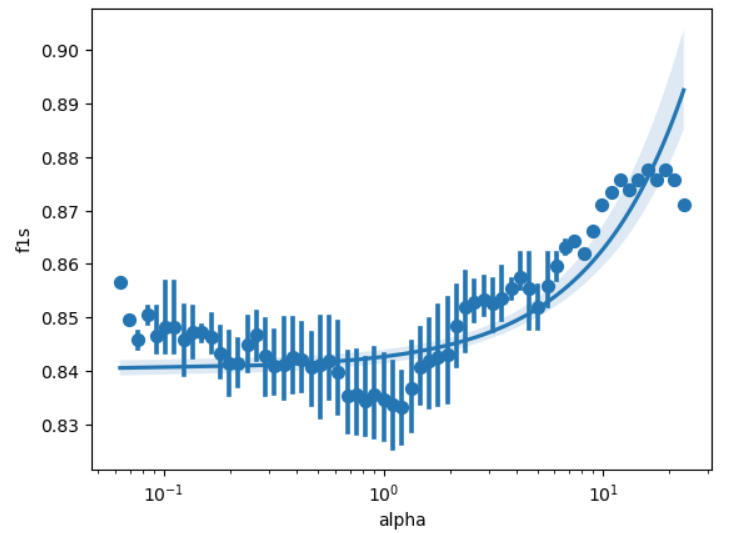

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(tmp['train']['text'].values)
tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
train_tfidf = tfidf_transformer.transform(train_counts)

test_counts = count_vect.transform(tmp['test']['text'].values)
test_tfidf  = tfidf_transformer.transform(test_counts)

clf  = MultinomialNB().fit(train_tfidf, tmp['train']['label'])
pred = clf.predict(test_tfidf) 
prob = clf.predict_proba(test_tfidf)
pos_prob = [x[1] for x in prob]
np.mean(pred == tmp['test']['label'])
metrics.f1_score(pred, tmp['test']['label'], pos_label='pos')
metrics.roc_auc_score(tmp['test']['label'] == 'pos', pos_prob)
metrics.average_precision_score(tmp['test']['label'] == 'pos', pos_prob)

0.952919935531447

In [28]:
len(valid_n_full_settings)

287

This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.


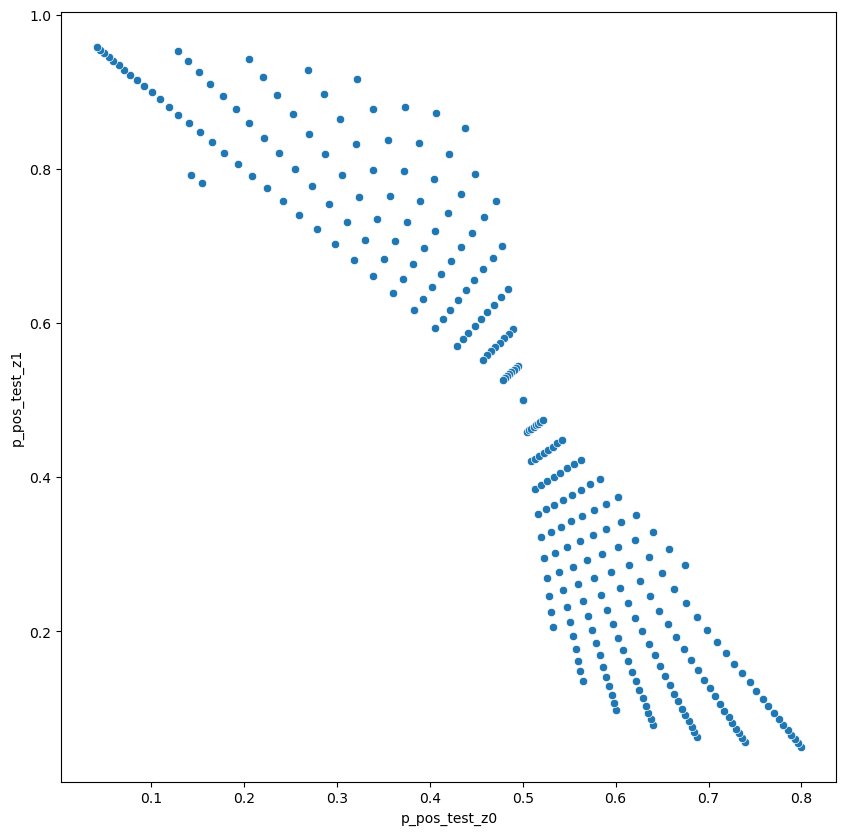

In [29]:
# check distributions of p_pos_test_z0 by p_pos_test_z1
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_n_full_settings])

plt.figure(figsize=(10,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)
print("This plot shows the probabilities of drawing a positive example by site/domain across all configurations generated within the constraints of the parameters defined previously.")

<Axes: xlabel='alpha_test', ylabel='Density'>

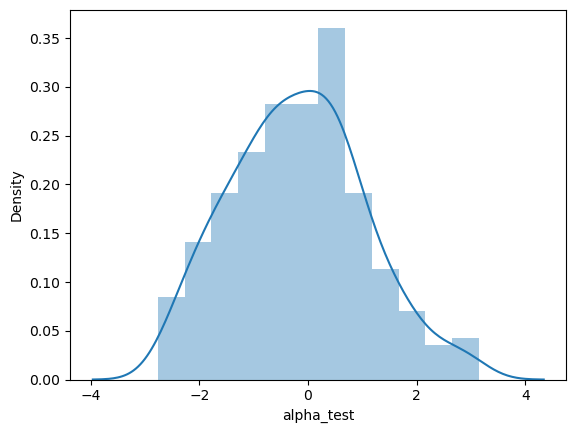

In [30]:
sns.distplot(np.log(tmp_df['alpha_test']))

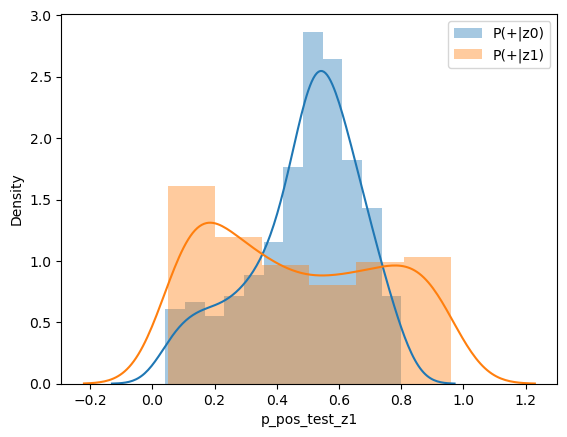

In [31]:
sns.distplot(tmp_df['p_pos_test_z0'],label='P(+|z0)')
sns.distplot(tmp_df['p_pos_test_z1'],label='P(+|z1)')
plt.legend()

In [32]:
tmp_df.head()

p_pos_train_z0  p_pos_train_z1  p_pos_train  p_pos_test  p_mix_z0  \
0             0.5             0.5          0.5         0.5       0.9   
1             0.5             0.5          0.5         0.5       0.9   
2             0.5             0.5          0.5         0.5       0.9   
3             0.5             0.5          0.5         0.5       0.9   
4             0.5             0.5          0.5         0.5       0.9   

   p_mix_z1  alpha_train  alpha_test  p_pos_test_z0  p_pos_test_z1  C_y  C_z  
0       0.1          1.0    0.385543       0.532734       0.205392  0.5  0.1  
1       0.1          1.0    0.424098       0.530555       0.225007  0.5  0.1  
2       0.1          1.0    0.466507       0.528178       0.246399  0.5  0.1  
3       0.1          1.0    0.513158       0.525588       0.269710  0.5  0.1  
4       0.1          1.0    0.564474       0.522768       0.295089  0.5  0.1

In [33]:
tmp_df.head()

p_pos_train_z0  p_pos_train_z1  p_pos_train  p_pos_test  p_mix_z0  \
0             0.5             0.5          0.5         0.5       0.9   
1             0.5             0.5          0.5         0.5       0.9   
2             0.5             0.5          0.5         0.5       0.9   
3             0.5             0.5          0.5         0.5       0.9   
4             0.5             0.5          0.5         0.5       0.9   

   p_mix_z1  alpha_train  alpha_test  p_pos_test_z0  p_pos_test_z1  C_y  C_z  
0       0.1          1.0    0.385543       0.532734       0.205392  0.5  0.1  
1       0.1          1.0    0.424098       0.530555       0.225007  0.5  0.1  
2       0.1          1.0    0.466507       0.528178       0.246399  0.5  0.1  
3       0.1          1.0    0.513158       0.525588       0.269710  0.5  0.1  
4       0.1          1.0    0.564474       0.522768       0.295089  0.5  0.1

<Axes: xlabel='p_mix_z0', ylabel='Density'>

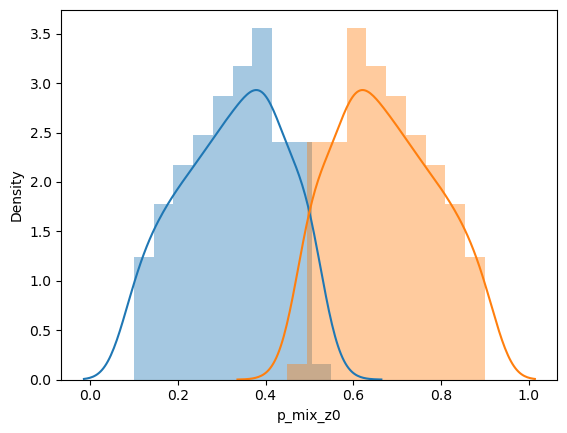

In [34]:
sns.distplot(tmp_df['p_mix_z1'])
sns.distplot(tmp_df['p_mix_z0'])

## Check Structure of One Resulting `dfs`

In [35]:
tmp.keys()

dict_keys(['train', 'test', 'setting'])

['train'] and ['test'] are of the exact same format as input datasets:

In [ ]:
tmp['setting']

In [ ]:
tmp['train'].head()

In [ ]:
tmp['test'].head()

## Classify

In [40]:
#metadata
print(len(tmp_df))
tmp_df.head()

287


p_pos_train_z0  p_pos_train_z1  p_pos_train  p_pos_test  p_mix_z0  \
0             0.5             0.5          0.5         0.5       0.9   
1             0.5             0.5          0.5         0.5       0.9   
2             0.5             0.5          0.5         0.5       0.9   
3             0.5             0.5          0.5         0.5       0.9   
4             0.5             0.5          0.5         0.5       0.9   

   p_mix_z1  alpha_train  alpha_test  p_pos_test_z0  p_pos_test_z1  C_y  C_z  
0       0.1          1.0    0.385543       0.532734       0.205392  0.5  0.1  
1       0.1          1.0    0.424098       0.530555       0.225007  0.5  0.1  
2       0.1          1.0    0.466507       0.528178       0.246399  0.5  0.1  
3       0.1          1.0    0.513158       0.525588       0.269710  0.5  0.1  
4       0.1          1.0    0.564474       0.522768       0.295089  0.5  0.1

In [41]:
valid_n_full_settings[0]

{'n_train': 2000,
 'n_test': 500,
 'n_z0_pos_train': 900,
 'n_z0_neg_train': 900,
 'n_z0_pos_test': 240,
 'n_z0_neg_test': 210,
 'n_z1_pos_train': 100,
 'n_z1_neg_train': 100,
 'n_z1_pos_test': 10,
 'n_z1_neg_test': 40,
 'mix_param_dict': {'p_pos_train_z0': 0.5,
  'p_pos_train_z1': 0.5,
  'p_pos_train': 0.5,
  'p_pos_test': 0.5,
  'p_mix_z0': 0.9,
  'p_mix_z1': 0.1,
  'alpha_train': 1.0,
  'alpha_test': 0.3855432894295314,
  'p_pos_test_z0': 0.5327342110958297,
  'p_pos_test_z1': 0.2053921001375326,
  'C_y': 0.5,
  'C_z': 0.1}}